In [12]:
import numpy as np
import base64
import cv2
import matplotlib.pyplot as plt

In [14]:
import joblib 
import keras 
import tensorflow as tf
model = keras.models.load_model('./model.h5')

In [15]:
import cv2

In [16]:
###wavelet transform
import numpy as np
import pywt
import cv2

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)
    imArray /= 255;
    # compute coefficients
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)
    coeffs_H[0] *= 0;

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [17]:
def get_cv2_image_from_base64_string(b64str):
    '''
    credit: https://stackoverflow.com/questions/33754935/read-a-base-64-encoded-image-from-memory-using-opencv-python-library
    :param uri:
    :return:
    '''
    encoded_data = b64str.split(',')[1]
    nparr = np.frombuffer(base64.b64decode(encoded_data), np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    return img

In [18]:

def get_cropped_image(base64 = None,file_path = None):
    if file_path:
        img = cv2.imread(file_path)
    else:
        img = get_cv2_image_from_base64_string(base64) 
    
    #configuring pretrained model for cat detection 
    config = './ssd_mobilenet_v3_large_coco_2020_01_14.pbtxt'
    frozen_model = './frozen_inference_graph.pb'
    model = cv2.dnn_DetectionModel(frozen_model,config)
    global classLabels 
    classLabels = []
    
    file_name = './pretrained_labels.txt'
    
    with open(file_name,'rt') as fpt:
        classLabels = fpt.read().rstrip('\n').split('\n')
        classLabels.append(fpt.read())
    
    
    model.setInputSize(320,320)
    model.setInputScale(1.0/127.5)
    model.setInputMean((127.5,127.5,127.5))
    model.setInputSwapRB(True)


    cropped_faces = []
    plt.imshow(img)


    #detecting any object present using pretrained model 
    ClassIndex , confidence , bbox = model.detect(img,confThreshold = 0.5)
    face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalcatface.xml')

    #box of object and cropping image if a cat face is present in it
    for x,y,w,h in bbox:
        gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        plt.imshow(roi_color)
        cropped_faces.append(roi_color)
        face = face_cascade.detectMultiScale(roi_gray)
        if face is not None:
            return cropped_faces



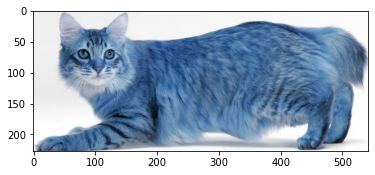

In [19]:
imray = get_cropped_image('data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAQDAwQDAwQEAwQFBAQFBgoHBgYGBg0JCggKDw0QEA8NDw4RExgUERIXEg4PFRwVFxkZGxsbEBQdHx0aHxgaGxr/2wBDAQQFBQYFBgwHBwwaEQ8RGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhr/wAARCAF8AoUDASIAAhEBAxEB/8QAHQAAAQUBAQEBAAAAAAAAAAAAAAECBAUGAwcICf/EAEkQAAEDAgQEAwUFBQUHBAEFAAEAAgMEEQUSITEGE0FRImFxBxQygZEjQlKhwQgVYrHRFiQzcpIXU4Ki4fDxGCU0Q2Nzg4Sywv/EABoBAQADAQEBAAAAAAAAAAAAAAACAwQBBQb/xAAwEQACAgICAQQBAwQCAQUAAAAAAQIRAyESMQQTIkFRBRQyYRUzQqEjcfBSgZGx0f/aAAwDAQACEQMRAD8A+3kIQgHITUIB90iQJUAJyanIBSmJyUiyA52SoQgBCEIATm+aE4BANGi6X0SWTggFSZLlKnIBtrIQhACEJnVAdNEiZdOugHWRZNBulQAluk/ypCgHXSgpqEA7MjdNS3QCoRonIBuVOTU5ACEIQAhIUiAchNvZLdAKhNzIzIByEIQC6pUl0XQDglypLpUAlkqEIBLJicnIBLpEJyAEIQgGpySyRAOTk1qEA5CEIAQhCASyVCEAJClQgGoTkIBqUJU3MgHISXSoAQhCAEIQgKtLZKhACWyROQDLJU5JZAIhLZIgHJSm2SIAS2SpwCA5WSrplSWQC5U8Ji6IBbJcqaCnAoA2QhCAEJbJUBzISEFdU0hAcuqLLpZIgE2SoQgBCTMUqAEIR5IAS2SJboBE77qalCAUlNBSXRfVAPzISXRdALmTUIQAnIQgBDUJu6AdmTlzTgUA5CEIAS3SIQHRC5pboBUIQgBOTUIByEIyoAQlCVACEIQAnJqEA5CanIATUIQAhCEAIQhAIUqanIBqW6RCAcm5k5CAahOQgKtOTU5ACUFIhAOThomoQHQ6hNypQl3QHO10tl0skdugOY0TsySyRAPvfZKmtS3QCpyb/mShAF0qSyVAAKcmXTroBcycmXS5kA5CbmSXQCuTUXukugFQhCAanIQgBCZdKCgHJl0qEAmqAnpNEAqEIQAhCWyARCWyRAKE9NalugApE5CAahCcgGozJyb95ALdKkCVACEl0qAW6RCEAIQhAOTk1OagHISXSIByEIQAhNQgFulTUIByE1LdAKmoS6IBEJyEA1CchANQnIQDU5CEAl0JUICrQmpyAcChNQgHJ4TEoKAeCnApl0oKAcnJL90qAZZJay6JqAQDRIn3TboBd0oTMycD9UA5CbnSg3QCpLpUzRAOvfZF1zulQD7pl+iE1AOv3ShNukQD7oumApboB10mZCEAJbJUoQCpLaJUIAQhCAWyXKgHul0QCZUZU5CAahLolQDUJyEAIQkCAVCWyLIBEIQgBNTklkAicksnWQCIQhACEIQDkIQgHIQhACWyVCAElkqEAJLJUIBLJMqchANQnJLIBE5CEAIQhACEIQAhCEAIQhAVIKcmAp10AqEl0XQCoQhACeCmIQHS9tU7MuV0XQHW/dGZcrougOl0XXO6TMgOt0xJdF0A9Ldc7ougOl0XTEl0A66Lpt0qAW6RCEAIQhACfdFkiAc1OXMXTwgFQlKNkAqEIQAhCEAJLpUIABRuhCAcNEZk1CAfdKudylugHXSrmnZkA+6AUgKAUAuiRCEA5CUJEAIQlsgGIT7IsgCyLJcqLdUA1CchACEZUIBQlQksgFQhCAEIQgHITU5AJZFkqWyARJZOskQCWSoSG6AVNS2SoBNUqSyVACEIQFG1dEwJW7oByEIQChKmpQgFQhCAEIQgBCEhNkAqFjcR45Zh+Jvo4qV9UY/jcHBrQeoudyrrDuJaHEAwZ+RK7QMfpc+R2UOcbqyfCVXRcIQhTIAhOQgBCEIAQhCAW6RCcgFskVBifF9HQcxlIx+I1MenLgtbN2LybLtgGNtxiLNkfFMNZI3aFl/Too8ot1ZPhJK2tF2jKhHkpEBAnBKlsgFQhCAEISWQCoQhACEIQCWSoQgBCchAJZIuiSyAbZATrJEAJQkypQgFQhCAE8JieEAqE1OQDklkqEAISFKgGpbJUIBLJUIQAhOSWQCJbIslQCWRZOCLIBtkqE7KgEslQnIBqE5CAblTU5CAahCEAIQhACEIQFNZFkqEAtkichANQnIQAhCEAIQhACg4vV+5YdUzjV8cZc316fmpyo+LXlmCTWbcue1o+Zv+i49IlFW0jz6jpfikk1keS4k9SdSpwiFrs0d3DQbqO+R0TGtya+eiaKtgFpA0E/g2/NZD0mvo2PD+Oyf/ABcRa4Ef4Tz1HYrULyynlMuXJMCQbtGaxC1+BY9zH+6Vrss33SeqshOtMy5MXyjTIQNULQZRbJE5CAahOXCrq4qGB81Q9scbBckoB1RUR0sT5Z3tjjaLucdlj6/HZcYDoKZzqekdoTs6Qefl5KoxnGJMdqGZHOjoo9QzbOe5S0xLMoGllmlPk6XRshi4q5dk6LDoYoLRs0spnC7ORik7N8zN02nlbktmddWGBRWxCZ+X7mh+aJK1RKX7XZqLIsndEi0mESyVCEAIS2SIAQnIQBlQhCAEJyEA1CcksgERlTkIAQhCAEJbJEAIQmzSMp43SzvZFE34nvcGtHqTogHIXm3FHt14Q4azsFY7FKhm7KWxaD5vOn0uvHuIv2ua2PO3h7AadttjM50rj9MoWaXlYYOnI1Q8XNNWon1Ul2Xw5V/tT+0Soe9sVNS0wG2Wltf6qqP7SftVe28FTQtkJPgbEwvt6G6q/W4fst/Q5vo++UL4Xp/2iPaI+IuxCtma4bcunaRfzACusL/aT45oyx9fya2E/wC8p7H00H6qH6/FfyT/AKfmrVH2g1OXzJhn7WccZY3HMB0vZz6aUj55TdbjDv2mOBsRY0iaphk6scwG3zBWiPlYZK1Izy8XNH/E9jQvOKT26cE1lhHiUrL9XRafUFafCuOOHsaIbheMUUzj93mhrvoVbHLjlpSRVLFkj3FmgQm5xuS0f8SUFp2LT6KwqFShKhACEIQAnDzTUIB3khNzBAeEA5OTQbpyAElkqEAIQhACEIQCWSZU5CAblRlTklkAlihCEBSpyQJUAIQhACEIQAhGVOQDUJyEA1UPGAd+5HvGuSVriD21WgVdjoiOD1hqP8JseY/Iiy4+iUXUkzyisrWxgPLohcdW6/UKnk4hoon5SGSv3t4iu2MPhifyjFLLc+EB1iqcRvjJdHhkWUbmVz5D9Nlk+T1dVsuIMdZU+GJuQdm2P9F2kxWWCNrjNzWRkHpnj6XHkqOXF6xjLe7RMj2AaxrAPpdUWK4hVVobHAx7ajYAuFvk4baaqjLJRiyUI8mezYB7T8MZFTU2N1LaWaUlsckujHEbjNtcX+i1s/F+CUkAlqcTpYoyMwvKLkeQBXyPjeMRVGH1GG1gcJWkSatsQ5ugcPrYhecYzVmgomOkr3iWN4uGO+K5/wAP16LJj/JSXtcbZZP8fGXuTo+8h7SeE72/flL0/F1+Ss6DifCMRZnoMQpZx/DKLj1G6/OfGOKK6OsfFA7K+zXR5XXve4y+uimx8UzyUb2h7myNiJMuY3zbWIH5q9edNU5RKv0MHqMj7R479teDcLxOgwt7MUxAfExjrsjA3zOHXyCzVN7QKvjnDqSsqKb3GCYuMcIeTdoNg4nzXzSI2yUjIKevZNM+MSFznaSXGpafLsvUeH8bZPh1HSUb/tqWJrAwa7blYZefPJk49RNa8GGLGmtv7PThWNi0bqfLVTKbEWX8Yc0/5VmKGeZ4ZnzXtcgNCs4qp5fkikyu3N4g7RepGVrRlcdmrpcVbJJlZoGjU5SP5rW8MXnFRUE3BIa23lv1WEoJ5H2ijEMn4vBYr0zBqcU2Hwss1hIu4DQXK0Y7bMmeoxosU5NS3Wkwi5UIQgHJqMyEAIQhACUJEIByEl0qAEIQgBCj1tfS4dC6bEamGkibu+Z4YPzK8+x324cLYQ/k0T6jGKk7NpmWZ83m2noFCc4Y/wBzoshjnkftVnpKXoSdANSTsvnjGfb7jD7/ALvpqLDIz8IymolP1s0fReUcS+0XiniWQxYniVUymJ+Au37WY0AfULzsn5LDDUds34vx2afej63xn2jcL4FduIYzS80acqB3Nff0bdYPFf2icDo7toMNq6lw+F072QNPoLk/kvmONlfSAuo4ZZHO3e5uaQ+g6BVVZh9fKHTS09U+S93ZrAf6Qbrz5/k8sn7UkelD8Zhj+92e84j+0fjFSXsw+moaQn4AzNO789PyXnXEnEuNcWnmcTY9UMj+7G5zsov2YNAvPqKHGZ5WxUEXLJJ28NgtKeGKpkbHYpikUXUhl3uHqBp+aw5PJz5NSkbYeNgxbiqZUDhuiqHkQV95L3Lnt6fW6hVnC7KYuDK7W98scTibepNgtSafDYWCON8s8oHie5xbf5DZVdQ2UvAoqa8R+8Wn+e6oU5fZbRFp6ChZHlAq3PIsTJci/lYLk+Woh+zpoZRbQEMsPW6s6bFI6ctZ4c7TrncWt+hXet4jeA3wxBvTksuP9QXU/si7sqGRVjDnkdmG7jmzEeWi7f2gp2M5LKZzyTZxa0gD1BVthfEFPV5m/bQzH4XBxy/mnVmHy1MubKJc33tGuA76iylaI+5dlS+jbX/aZITG/wC5LYHXtbUJX8IQSwfZxxU0mwPPe039CLfmrvDy3C80RLGyX2c4OHyFrLpUPfKwuliimid2gNrfJdUvoOzz+XAsbonuEEjrNOgMoBPmCbKtl4mrsLeWVc0tLUg2u5mnqvR2VGCRU7m1cUvKJ+CJzQ0H0OoUo4Rg+L0b44JXODh8M7ASPQgWIWhSX+SKW2uiBwv7cMdwSCLl4lLPBoAM2dv0IXtPDv7Q8lWyNlSyKaQjRuxPpa118v4h7M2U9W6SixT3eN5+CJ2ZjD5joO6rmx4zgb/d8RpudS8wBtVD4gOx06rUpzj/AG5md44T3OP/ALn3LT+2yOV+VlO5h6iW4F/K4/VWcftjiYM1RSsIO1n2/mvjSDGcXp6QVdJPzYhu0X8bR5HW4U/D+O6nnNbKWkg3bIW737hR/XZ4ds7+gwy6R9hx+2GmlF48PcR35t/0UyP2q051koXRgdS9fLtFxo+pAY+TUfSxV1BjXPZo5unbZcX5PKQf46C+D6Gl9qlN/wDVTW/zPCoq32wkf4cLevzsvHjWySsBOYjo3Kf5rnHPLJK4QUri9273aqMvyOZ9HF4WJdo9Xi9qdXIWuqfshvkbcaHa53JV3Te1FmjZYXZf4V4lT0FdUkvPwA3+LdXFMyakyukkyMGlt/zK7j83P9kMnjYfo94oPaDh9TkbJmjLtvD+q1tJWRVcbXxPa4HZfPdJiNNO37apbr0LuvkLK0ouLX4NK3kTfZ/5jlP1BAXrYvKde88/J40f8D3lCxXD3HlJixEUkuWbsba+lls438wXGUjyW+MlJWjFKLi6Y5CEtlIiFkiE5ANQnIQDUJySyARCWyEBRhKmpyAEIQgHIQhACEIQAhCWyARQcYp/ecLrIer4nAX2va4U5RMXrYsOw6pqJ/gZG42zWvpsuM6rvR8/yY3WCOp5uW0Ryte1tzt1AHRUIxytklY6dzZW58rm5Sw69iTYqjk4rjroql+H1DWviqXA2+Ia6X9FMGPyv8FaGtlczSQNsHj/AL7rxnm12e3w+aLw8jvaXcNc0EvHY3uFTYvV0tNDo10JNyCLHLra1ha6jT4gxkTgck0ZGZttBpvbsVTsY7EDIXvdJG0l0ZOptp/ILDkzt6RfjxfLKqtFTWhz6gtfLELR5d5L3ux1+pF7LE8WYG9+HTvp38pnKDmyudq1pIJcB36L3HBOGhWyc2Q2Zo9pGhtruOwvp2K86x3H6FntA/s3PTNdC7wuJb4XO31HQCxKpipRXIuclJ8TA4TS0OI4BDVRh1VyoyS4fGSzS1u1lxwQwYpWvpYmX1c+RwaQXBzdPncq7r8Ii4X4oxXDqNksMFdTGop4o7kiRu4aB3OtlWcFh2FcUxTYgx0MgicH+HVrwbZD/FZtr91c+mcT2jQ8L0EWesw+SRs89GeWW/fHUEjofMbr0Lhaibh9XzqYuMRuXH7xNhoLrzvg+mczCuLeKZ4c8zatxuG+NjBvp6L2jgumZxJwxBiVAGmOUEtafw9L2+qzSg3KyxzqFGopMRbkaGDNdgLj/wBSpJmaXs5dO6QyaZWxE2t6FZvlHD5/s5GyM3eDqbj9Ff01f/dmODrdbDW581txZm9Mxzhx2jT4dHDyzkiljcPvB1z+ey0eGccU8cop6zNEBZrXHc/MaLzwcUNw+K1ZJy5ZDliZltcnsqXEzVEl0jnN1uMupv53WmflPDTRS8Hq9n0hT1kVQxpifnB1BUkar5OqcXxCmjz0FfW0xd8Qhnc25HmqN/E+NvktLjmJMcbgCWoeR8tVpXn45K6M36Gd9n2cluOq+PYOKeJII8jcYquX2bOf1UOr4wrtqzEMQG1i6sfb8jZRl+QhH4Jx/Hzk+z7Nzj8SA9v4mr4pn43rxmZSV8ziB96d7r/mqUe03iegntBXvDQb5WOe0+u6q/qmP/0stX4rK/8AJH3lcJCbL41o/aXjtfT5qjFpo79pX3v8rqvxPiziOcZoMeqDbVwM+WwXP6th+mP6VmvbR9qyVlPBrLURR+rwFW1vFuA4dpX4xQU57Onbf6XXwrWYhPU5H19VNUyE7+8HL6m5UTmtp33e7nA/ibn9LAKD/Kr/ABj/ALLV+Jf+Uv8AR9n1/to4Jw8uacbhqHD7sDXSH5WFlicR/ah4bpi9tFh1dUluxfaMH+ZXy3iEb6skwO938z4CfyVfTGpjkLg7S1muLC/6aqiX5LLLqkXx/GYV3bPo7EP2n8UqY3fuTB6ekYN5Z80hA9NAszJ7deJsVzCfG+VHfxNp4uUPS7Rf814rz6mtlkikr2xlgsGiIAn8yq+mfPSV7W1LHVUINnRlwsfO4Kzy8ryJ3cjRHxfHh1A9Sxfiv941GfEa+WdzupY559LnqqObiOOn1p6SUdeY9p/MHRDI6WeJjYKNkObrDESQP8x/oudRhzLcueR3LOuQNBef+/RYm3LtmpRSWkdqCvxLERzpZHSQt3ZC0DT1Oi7VGMVmHgGko4YnPNmvmlafoAo8WDUt/HM+VtvFGWXsfQWKtpMHgngaYcshA+Isym3YXOllGvoNq/4I4kq6yEurMRhjNvEI2tYFEkqY6UMYysljB+8W5wfToueI0cFFAIzH9oBv8dvpoquindUPbTc1zIvwSN0t5dvqufFnVvosf3/WUcgffmRDXM1oDgPluu9XibsRgfLT1kWY65XNs789FHGDmCpzUmazrbv8P0WkpKCKmY33qmcY9LZWB17+hXdHOjH4fzaiXLUB2mrQxhd891sKd7KaBtoppRbUv8NvlddJ8GiIz0T2RtG8bmG48rhV1fHIw8uKVkMoHXNYjrY/1UEjrfJHGtpoqyR2TM134g8HX6KslwnEGH+8SMliOgDmlh+RAsUgx00T8sjYXPHwk2ufIXVrh/EoxCX3eR8UUT9Mj9wfQ6KSvtkX/BAo6d7I+WBmZs1uUO19SrCCLE6N4tG9wdtllsfpZTDhFKc8sb3Ov/unXHomvFVHZtG5sMdtXFwJ/NBdo5yyYYyRzsYyxzX1BfrfzsrKIYXVjLAyVptYSRPJ/JZjEaeV8bxUcrOdGvdv8rIpI5cLEUgqGy5bZssuWw+atj2Vy2ifW4RXRExj3WeF2oM7LG38Tk2iiqsKjPuTKWpL/ihzOAB6ZXWV1RhmJwGNnjDtXhzdflbRR5+HGRzvNO+VjLWIDspH0K0rRS3Zw98iu41tBFBUndzmNfnHYWIU40eFTU15Kn3a4sW+5uDSOxIBVWRSwS8qvz1LXfde8BzfRxtf6qTT0j5HtEETDA3XJLK6xHnYKf8AJX8kGpw+KnZy8LqaURONy1zg1hPz+ElcJOEm1MXOowyOb8BcHDXcBwvotLHPUPY0R4PTiNuhyuDv6FcYqbD+ffmPw+Y7sbmsfldVTimi2GSUTBy4dU0E/wBpG+MtNtHX0Wp4fqZiWh7XWbsMup9StezD6Kpj5ctXE8kWvlIP5rL4pwviGFSuqMMmbNS7uYJQHW8llljNKzKSro10FW8lnMbaPsGq9ZKeUD4WC2jGtuAT3svNsK4iZFFZ7HGRu7ex87XW84fxSPEI9fittsbKWNrlszZYySsn8mqIzQPaB0Bao89W+J7feI+YPxjxG/oTYBT61k4GuoHw2aLW9d1EZEyojzP8bB8TcxuBtfVbYxSMTbZBqRDKM5ZMDa2cOLR/pvp/JU09ZWUekdeyVn+6nYLfJ4tYq3q6JtMCAXMa74SHHI7v6FU1TGJ3vhk8Zscknf8AhP8AQqdnEPwzi0YdWMFW2Wklv4QXWHq09V9Fez32g0uLtjoqupa6cj7N5sOYPJfJdQeWx8FQ1pj6xnoR95t9iE/hziOpwattTv8AgOZnqOre3mtWDM8T/ghmwLJHXZ+gAsdULx72f+2BuORRU1ZExswAGjrEn56L1qmrI6lgcw79C2y9yMlNWjxpQcHTJFkWSoUiA1CchANQnIQDUIQgKFOQmoByEIQAlukQgFulQkugHoSXRdAKq3FYI5qOYTiEgsN3TtzMaOpI6qxuvP8A2u1NXTcLTOo5HRjXmBu5aoTfGLbJRXKSSPjv2m1tDhfHdVFgc7jQSENL2sDQ543IaLC19lLZitQfd2FzKjmWBDXkXHYtOyy2NYc2SvFdLmjkYbxtLsx9SFVsktUSPnY1xd97fXoF83Oan+0+hjFx/cet82EMDYswG7gXXsR6q7w+h97eyR72whnizPsxoA63XmFHjMFII28x1TWi32UTi92vSwVLxzJXYzxHhOC4xM+gpKzxvgjec72hpNidteyphBSb5F0m4xtH0PRcccEYIXUf9psNNUT4mNqmk5jvoevoVjsR4KpcQ4/j4opJmvpnReJrdnuA8Lh8l8w4jwVSVvtBwTAom0uHYfVveJKibPkAAJsSASDYCxtu7svR+BeIMT9mfGVJwti9Y+swGvuKGSV13RH8F+2q2uEOKin/ADX8GCGWTk38npGH1EmK8Z1Jkhii5GaNxPxxxloLS3zJVvTcMQx4mx1ZFzYqgkSOyDUWB8Q669tyoOKQHDOPKOaNtoa6mPNPS7dQ781uqNgqZA7mWszU7gW6j1WWUKlRpWR1op8HwJk+KYzhcbGyUs1EGvHQvzENc71a7/lWj4BwrD/Zpwg+hxnFaeLxucHzyhjWtJ0GvkuT8RZwhwdjHENSG5zKct9C4NADb/Mr5s9plBXYxQQ4rXVNJPiFTJd0+I1XJpqdgaXZW3IDb2yjqSrIRXOK+X0Vzm1Bt9Kj6Vw6LA8cNRVcN4nDioJJe6GVrgD2Gq7xMZSsla8Pbk1LM1/mbbr5Z4Tw+PBqzAccwfPTSVkscUtK5xaHZmgi5330N19KU2K0NXWPo63NheINFuTK8gE9wToQfJUNRhPRoXLJCyHJh1RX4/SuY5paBdrA3w37klaPEKh8AMNTC7mNFiwtLSfntZVmBAR4i5j9Sx53/RWnEdawVHLq2OsGAhzdyO9juoTacXK9iN2lWjPYq4xwSFkLGl4uGueAAsk+rE7Hxva3mjoW6fJXmI1sTA7kFz3uG0jQPTUrJVZdHUF7H8skbZb6rOpV0a4xtbJLK14p3NBaC3cFunyWXxPHGU8meVrCzudR+amxYo2WflyC3Qkbn6qlx+mbPG4xZHMdfT4T81bGpEmuJY0lfRYgwctzYwRqd9fkVCxHDJ3va6ifzI3fAWvzD6FZLBycMleyMxMIJ8Mlzoe61YqIauJoqW+6yN+F0dywn9FTKPGVF8ZWrO2GMqxA7O1sxGmUbn8wq+TG6j3t0MsLYyQRllaBf5DVVtTV1OGV5u90gJvE7LcG/e2iuHxRYiyF87+VMNS7TbyNrqtx49lile0QJcXpw8U9fM2lc7Zrm3HyO6mSiCmaySnzN0uHscTr+YUPH8KEBhfUZaiF2kchbex7ErnJIyCIQgCJ7tGtc27SPVdpVoblosJayaeA8ypbINyQ0g2HewsoNNjr4xadrjGDoY22Nh2tquE9I4Bgkbyy7Zzb/S4UiJmc6zysA/FZ23oupohW2SBV02ISCSlLJbalouHj6DVNq+ZUSB88zyG6MboCwDt3UWoq6GMudPle8aFzdHflp9VIiqGmJnu4e4n7haWgg+ZvqrNlWhYKmqpDzGBtdG06ODiXj5XV1TcUOng5dTROm5mmrQSPQjVVtTjFPBkjrWclx/w3/o4BWOEQOnewwPaWyXsQ65v5dVyWuzi2mOFI+I86mlcwm2Y5nXA9FaR1NQYgyOZsjurJLj6Am35KHX8J1Qk57JG6auaXuzflorWgwuMMbG8ujmcPwix9Soy7I2mrZSYhWVkcljO+EAXy8jMPqOip5K+pEokgeyeQdm20/wC/JanEcI5T3MkfLym7WfqPOyoPc6fDKgvL2sYd3udbf56I0TjJGowLEXzjNOGRuI2FtPLVWYqWySvbTnkP+8x259FRMZF7vHLk5TztIcpYfUrhUYi0604bHUN/j8LgP5KLWtHNN7NbQYjTB5bVzO0uLDS3kRZGN4O+qoxVYO9tRG3Us0Lvldef1mKGrObmvZUx2+9Y6diFOwbiSrpyI3yOkZ2k8Lvn0KR6EoPtM6QYdTyP/wDcI8hz7Ob179bLrivD8UrI5KNrRNHo1zNCfXofRS8RxAVBF4Wjrc+IH6KHHiDKaQEP5YIsWtdfTzB1UW3ZOtHSjfV00QZI7lSgeX9QuJxuTn5a+JvkS3f0sraWejq4ByHZzr4i3XOqV+Gcx5MrL5TqwNOoPbzXeyKLKOiOKRAxSthsfDmY0kfquNfgkOERulxGvaZnHS72uJHbKCutFWR0b7wBvJ2IkfsbbWOxUXFBHWzs8V76kyuBsfIXF1px1RRO7sXDMRipKgNkY73d5uJYnFoB/iA0TeIHxV5c2mq5aR+gMheSD6WCZTUEU4kiZO3QWAa2wB8upUE4ViMTHB9XCIwLNZO8scbdiFevtFUu6NNwvhdI+LlVdcyuYdg7r5FaDEeH8PMQJiigA/3LH5jbyBXmtNj9RQScpzKeod2D2i3oRYrY0fHkAipmYhIynYL/AAOLTfzINipJOtlc38xZd4Rhnu1uXh0LKYjebNmPnYlJU1GF80xT07oyPvt8ITYsRw7ijLA+ie5h0E7Z3DXvchB4DdRfa0hZV21yVDQ/fvdRpfAvfuIX7voI5DNBWPN9rW+imUuJ0MRy1EzwdtXC38lArMVqsILY6nBKXlN3Dado18rXS0PFGCTyNFZgtK0ndxgBt87LLNxv6NMVJr7/APgvH+4VozQTRFxHRoF/IkJaenNPK18bMhGvhuiXA8MxSMVWCNZSy28TWNs03RHh1dh72Nlc9zeh3H5ql2nZOk1RfSVEr4mmN7zaxsLXt81xqc9IY6mB943nK+zbjXa/8lG95MDfhcCN76rq8snppWvymNzDbex/8FboS5I8+UaeyPJOOY+KfM3OdDmuCf6rL4++SjkEuZ2S+Xpv0v69FYPxM09T7vWZhmZ4HHa4UPFwa2iNtHG7JWHUbXa5t1O7JJUzL4hOZ5GTM+0ZIzMHHfTQhRa+mIp462nzODDlkA6WXO0rKedxzARAG3YO0uPmuNLipFHXx1GUh5GuxuBa/wA1dHaOS0Ow7imu4erPe6eT7N0gBzNuy/S/4b919c+yD2kR8SUkcVR4JToHB2hPZfBNZiLow1r3OLCcjmnYi+hX0D+z3UuFZGaOb7VludA/aSPo4HuF6OByhKvsxeQlODfyj7eYbgEJyj0hzwMd3AKlL1TyBqEtkWQCIS2SoBqEZUICgukSXSoByE0FLdAKhCEAIQhALdF0iEAt15p7YZ5GcPObHs99negXpS829r9Q6Dh+bNlMZ72Gqpzf25f9FuH+4j434huyV9nWeSdR0Xn2KzPZ9jTOzVB8IA6LfcSztY9783MO4a3XU+igcMYJJnM5gbLJJqczCSQel181D2n0c1yMLwpxTVcFYmZKuj5ud9359SbedivWeLMHp/aJhdDjPCk3JxSieJIg5tiCNSHDeyqOLOA6nEaczUcLZMgze7O0ff8Ahd1CxeBV+IcN1eak5tDLezqd77SsI3uDuOy0yXJ849lEX/izQnH8To/tMT4VqxirBZ0kDA6N52uD0usdjtNxRiNbS41ilBLSRQVDHQwn7uU6En+a9ywP2l1VaIm1NKyq8F2uliAuB3IVT7R8blxxlNR01PywbczltsBft6KiGRY5aiv9/wD6W+jy3/5/9HoElXQYpR4VWTzNfIKcNaI+7gCrjAKgU0nLlzygDMHN9fhNl8/0+KPw/lU7J3CMSFkbi65sNF67w1idqFjQ/ObZi/z6rFPJkcrNi8eCiXvtYrf3n7PIaXh+ZgfPWNGTKMwcCDYj1C8TfiM8FFNhHGmA1Xu0YDWnkGWKUC1joL3utfxAZsTrWUtMeU8TtkbbQB+tivR6Ti18mEUjqvD2OqmM5cxkYBqBq4d1KOd5Eoy+COTxowjf2eQcHYHXcacS4XV1FBLhXDWDv515mlrpnjrY9FsPaLx3hWM1H7qw9rZpoTeOYO8TCOxspXEfEE1Xhk3uc0Ij18Gfltt3O30VD7PuFJ63EGTspqWektmfNC3MB2FytCdlKjxLngrG31kUj6iZ5rKewd3LR6br0XE2RYxgYqfF7xT7PbvlKxGM4VBw1xDBOwRQiUWeG7kHyC2mCVMAjkpZC50b2EWDehVDVTaZOTtKUTDVL6lhysfmP3rtubeTVR4pVsDmMjexjshzjL/XVaTFIvcqh8VPUO5TX/DNAdL9nBYnjN8ktOxsVQy/Q5bkAdnFUxhumy5S0VUcsL6l7mVLX9Da4se9lFe90j3xDK8nVpzbjooWD5ZQ8O8R6nufVNgovd8TcXFxYfiaNbHuFbpWT3IpcUp5Yq1okh5ch1a8O/JX2D1coDIpY5SRpcWOnYtKk19O+sphnbcA+F3VW2AshEfJqcj5Btmbuo5Mlx2iUIU2Z7EYoZY3vp8sdvj8JAI9Dq0hd8Hkilo3ctjZmM8LrWOndX2NUDIopH+7usLlzR4rDqQsPg9G+LFH+4PaST0dYPB3BGyrVSjbJq7o0FXkY/ksfzICL8uXXITsb9lBnAyMPJcYur2NzWI7joEs8kUmJvYMwc0AljujuoBXSOpjjrmRc3lPcLjLoP8AvuoEhxrL0hikc4RE3Y4t1Z2ThVx1tOYjHDp4Scx363UmenEAlfLE58NiZBlu3/v0VHRxxsxF0MDnxl+zehbuLjqpJasr22SqigDAyQs5gO5zbjvfdWGH4XUSvDRlkjOpY5ttPqpNFIyJwDw51jlPldXeDVsEc8sTxe4Ivlvl9Qo7bF0jKY5gBkL2+7ueelnkKZwvE3DC1tW9zRpbNe60+KsjYwOkY2SLYuY6/oQVGigoqhgbJ4e172J7eSuu9FPxZNr8QpywPZU8onYudcP9HAaHyK44cKitk5Je4RnqXXvfa1lQV+GSRxyNY9uVz7Pjbe5HQ22NlxjkqMLDMjnyNGoI3FlF6ZJbga4YJX0xkjnhbURn4OZobHoCFTYnhU7A9hguCCBmdm+WytMH4olqHtjldfMfiPX5FX9RWskZy6pjjCOo1Nx+amqZQ3KPZ55g0k8QNNL/AIA3jLrgfIqwrMPpjG402XS1h1HorCspIoJTPE8GMi7SHC4+fZd6KCCpzCeJuUjRw0Oqj80W3asyXujHzxZ38u27XN006gq8ZSNAHLp+dHYXcNVZS4fSQSMFRHfKdHbWKrq+N8FTH7tJyzawtpnHcdFwKXLR3p8LhnL5qZ74QOzut9spULFMOjDM7HZ5WC5Hwvt1sOysIo63wuBbmGzupJ6FSKiSCsjBqYbTsBBGXUW7Kv5J2zNUOJwMHusgc+N+jt8w+atqOMQXcZnSNIFru6bAkFUslI19S9wzOyai7crtPLqulTIHmIMY8DQsdm+910/RSStnZMnyUklO+V2fmAnweIHfXW+q4iN07yOUyoI1yyuyj8rK0oIOeYzUwuAGudzbt17KzqOG2VP20E00QGoJbdi041ZnnNR0QcPqgymcyZzabYW6jzBI1C6nh84rJ9g6KeI7v55AB7hoB/mphkmoqctjew5NLO0B9NOqqA/F8Qe4wZ6B5OmaUWIHYdFZbiil1JhJwXQEkPiheW6l7XXdcdB3XKCCPDpOXR0TJQBuadtgfmFKqBPhkbXyS82oPUan5AaKBDiOMzyudU07Yadxv9q0Fx9Qq3NtbLIxrqjV4XxrBR5qavoYohsQGNYb+g0V9T1dHiZz0dQ+GQ6iz9LehWYo8Ow3ES5tbEwyO2bnIB9ArOn4Yfh4a7D35Muojl8VvQ9lxSdEJRjf0y1LKvmvjlbTVTWi/wBo2xI76rvTRUFQeXX0DI+mjLBQ3zyRRWnZme29zl1afIqTTVLnsBeGyRm1iN1Bs6kTDw22BnNwp/L7AO09EQYpLT2hxGG42vvZWdARszMD2Uitwg1kRsxmf/LYrvC9x0OfxIoamNk4z05aQeg6eip31LoA+KVlgbgW016fVSK+nrsOfpE6w+Y+apq2c1Bs8ZD3DuvQJFtM41ZDxe88LXRhznAZmg73G9vUKP7z71RMcDpJ4XEaWFvyspskoD4436gg2PcHcFVlNEGSTRxfDIDpt4hsrl2c+ConZJI2SLaoadez2kWPyO6zNJJGyomjn1jIMbr/AIxsCtq8WnEsYvZ5jf6AD+qzNbRGKrqXll7kmT0HVaIsqf2Yisw8zwODDeWN7nNt1F7gL0v2MV9TTVtNWUWYuifqPK9is/BQNzyOy7EFp9dF6P7I8ANHWglmeKR5uR57rZB8mkZ5Kkz7ewCsbXYVTTj77ASOx7K0Wa4ODosLiif90W9R0K0q9s8R9ghCEOAhCEAIQhAZtCbeyS6AddOuuWdOzIB904LndOugHXSIQgHIzJqS6AV507Lyb2sYfBV4e/mB7nAaDMSPovWDtosHx3ROno3tga1hIN3He6pzLlBouwuppnx7U4fV09R9vTv9zvbO2zcmvorirrDgkVNJFPKQ4Gzm66fqrnGMMpoat8eJ1EOd1wc050B/hCqJMHpjHBB+8GvpY3/ZlkD3loPS6+bkpLo+ii4z7OuA1knFbJIqipqIcp8EuVtxbsLJcQ4Ckkzz1PJxu+kbxAYpWkdcwJBWzwDD6amYPcHS1T9zbIB8+oW7p8PhnpHCelZCXD8Ze76BbsUOcXfZjyzUZaPCqbheDCMOfUU9Li1fG14DuVRl9iejSNTYrrQSYZi5/dklPLhlWC5kzcQa5khsAbsuPEO69Pr/AHeJ+TDOKpqHlWJileImsaD4tAL67LP0+FYtWYi8nirD8SjjqCXR1kQeGROFsgda97rFPByZrhnpUeKce8IYhwnitMHsY/CLmWDEN47keIOt8K1OAPrZ8OhlpX080UgFpY3eH1Fl9G0XDTq/Bv3fjlLRGJsYZePVpHax2Xg+IcD1PDXE7+GsDYyPD618lTFNnsyFrgA4WG1jsAtUvFqKaR3x/JhKTjkLHgThjEuJcfa+PlVNJTn+81B0bEwHVt+ruy1+OGuqcZqcN4awRuP0EORrph9iI7gk+J2j/kvReG6Cg4X4XGGYXPDBeMgyObmJNtSQN1gpcDw01sNRX4zjGLBkbiI4WFkbGuO+UW06KjN4kYJNd/JGPlPJJ/S6Wysr/ZnXxyQ/uzDmXl+0kZXMzsiJ1zNAPi+qssKpMW4Uoqn39lLcA8ttN4WX9LCy9P4fr6H92GOgbU2hjs3ntOU2H3bry7jriN8pNJJQ1GQn4mNLR9dlJxhjhzbK4znknwo447Qu4joqSpqXtjkDMxIdc3GvRVXD9aX1eZrnSNjNmvy20HkpdQ/3/CoKKgzxNyDPmbrfycF3wDD3UT7SOYJB8bXtu2Qd7jqsMlzkmjTfCLTJPEzDU07ZQXggbOYMt/Irx7G6htTI9tRFcMuC3Na/0XuOKVtPBSnxcphFyHOzNPp2XiuPxsNXUOiDZYpDm1cDbz6Lko1tksUrtGWppDTl8bIZYoraNLr+tiuYxGGmr4nPe5uY2bfY+fqpkjGRsAjLWPB0ka4gDtusxWFzJWZ3Nlpg/wAbQ3xgjW9u64o2aeVM3NXUtpslXC1s1LJbmta25B9OyKeWnrIubQFsoYLlvUDzC4UHu9fRDlZTKwXLmusHjzC4U0DYpBNA9rZtb2bYPA0IPmqGr7LbrovRUe8U8QYWvzeEtOpBA0N1lcGp4YsemjkidZ5u09Lnp6q5njdQVcMsAcYpiCR2Pmo/uj4sdkfIzK347DbXqPIlR6TQX2Jj+DzMrDWBjeUNHPbu0HYkLNSwS1L+ZvlktcW8JK9WraTPAx0WrZGFpO/TVpHUFee4nhZp3umg+ykaQBEP5f0XIsknZosCqJRE+nqW5nZLAmxH5pH8MPqouezKDC+4DfiYO3oqOgxGT3yIHNCZA05T0I0K3MFWaOUThjWxPZlMf8QGv1XV2VStKymZh9TUSudTZZHxfEwOF7dcvcFS46JlXHzj9nNHs/Y6dCoktZJHV+8UWhJzRkdurXdD5KdWSnlCvpGOaHi8rehcN1ZFXIjNtIrsRfV0UeaVzSOpDgGuHn5qPBi7HsY7NeEnc7g9j3HqpEtRHjmGPZEGySWN4S3xAjoq3B8MMtBLka6RrTYjq0+fVWdFV2jRjEI3uYDE2JrmA3PiH/hR8RpLMaYnttJcsO4J8iqysp5IqdmvwnRobqLenQrkBXVNM0UhYRGbgZr+HqpSSSIw7LLAp4WStbO9hkdcPa5u3nqrrE+dRQSuo2umhdq5ua9iPwkbKHhdNTyvy1bOXUNAOuoPmCFbwSQQScmdjmh3wEO0IPVQho7k2zAVnEJqYzGWuGurRa6vMBrzPFlpGuYW9D/RSMTwLD5XvccpN/GQ2x12Jsqujjfw9UOeG8+mJsW65gehBXXHkwpVE08sRxON0YzRVbNBm69/r0WaqaOupqiM1E7eQ42PYEHqOhV1+82yMjnEt4zYC+7QToCqTEMVdPUhzHOkZfxtLd+hUZKhDbNDHVyFjBI3O8AFj43Xa8dDdcJcbile+GWFwmABI2Ol0tPU8qlJiF4bXZ/A5VT5nVrhVRiJ7x8bTuDsbdwVU0rLUmyEZ4Kes5zJXmMC7o8t7XPmranZGWMqWDmxPOUt2c09PkVAqGRk3ghvJs5ptqE0zzCRr6aGxZZr4XWBLehF9wrYpMjJtFpFiNRFXvo43McfuBzbC3Yg9VuaB81JSWrYWvjIGjXeLz20ssHHFFiM/MD8hb4tXZSw9uxWhNS5lOA8ObERo4uAJ9CFohpmae0izeTiL5Rh8LcjN3FwBv6FUGKcPzX51TWNpidGtc4nOfIAKzwrmyxl8s8MMe0cbmEuPmUtZyy9ojmZNMdGjxDX5KTbatkEuLpFZRcOVVUea+S4YPiLSz8zuouIRzUc/LbTNqutw03+oV3BhlVUyWxSVsVMwXsMztu46KyiggFmUWIReh0v6ghVvfSLLrtnnkuNTQVAL8NdG9tjmbcH53Wmw7itk+TmRVFOe5aSFdVlRTA8ueCKR53cx19FDZX0jCWy0rGjoWu6enRVvRJNSXRdUeJw1OjJ4pHHdp0cPkVJjEUErbHKDqW7j1CqP3dhmKAOZl5nQ57OHoV1OGSwC8cz5Gt2zanTzUHZxKP/AEa+gqGtY0xzMdm6HcFXdPiDbBs7L/5dV5eHzxTfZvt3aditFhmLkNDajM301CnDJsjOGrNbWU9PVxfZv+IbHT+a884iwg07+ZG+xabWLdLeS2GfO3PTyZhvlKjYgIa2Axysc14GrT8J9FqaU0UJuB57PEZI87HNuDmHl3Cjcp0ZcRreQEEbFpH6FTnxNpJ3wFzi1xIsdfTVQomOjnc38BsPNqhFbLG9EWtkdTvqmWtzcsn5C9lDxuK1JFUgXLvC70O6kYoQ6Rrg/PfwkHy0UXGJDJhdOGP+zL9b/Qj6haoKymTpaKmd7YAICMkjmaDp3X0R7JsEaaSlmey8Uwu49Y3d1831FQ+cOa/K+XlgA+Y3+oX2R7IKJsvC+F1DB4JIg823a7Yg+S34IXIx551A9TweDlUcf+W11ZrlBGI4g0bLqvVPKBCEIAQhCAEIQgMqhCEAJQkQgOgujMmXRdAPzIJSBF0AuZOvZMui6AeSbKgxuiinie+obm7X6K8uuE8TZAAW3HZcatHU6dnzdxrwoah8rqODl/xbErG4fw3U00l6iSWU9ImaBfUmL4NBIx7pGX7Ly/FaLJI9sTcjb/dba/zXkZPHUZcj1cedyjRjqd76RjfeA2mA1DIWjMfXp9VocHxmrkJIyRUrNHyu1Pew7u8gokVAySUunbaJhs4hupJ2a3u4/kr1jIoI2ySsZHFEy7GN2YDta+5J+p12CnCNPRyb+yeMLwzEbTT0dOQBmyTNBdb8bj18m90U3DlA1xmfhFPE0jRodsAbg+ZJKhZ2mWGHm8uSQiefxXsLXa35DX1creLHaeM/3x7WMJAb4tuwVyhFvaKnOSWmcKitLw8UdDKWvfmfe4Fxpf6rHVPDOK1mOnEjM3mNGRkeXw5Sb2Xq1PJT10YEBa8fmrBlFB7wJALOta/RX8EyEcvExdLHUwRwiek8f+8DbgedlZxUeIPOeOaGLLqPsrEAb2/mtHV1lNACwltwqKatBIs+2pPZUzUUiUJSkdKmrZHTmCaRkkjiM5a3wkna4GwPcLH4nhFQXl1G6WE/egl8RH+UnQrVxvpIp2U9w2VzCYgfvMO7L+XRRcReGeHM4x2DoyfoWlZMkecfcaMcuL0YhkEsWb7Fsr9nMDcjvkO6lUcscb3OlfymD7kzSPzVrP8AavyVDNR8MnXTof6qtxHHKSkY2HFIc/4ZW7/XqsDSj8mncih4sqaAU7zTsY2OQb57sB+W3kvEsRqWmrmDIW8oH4nOLgD0t6rYcS1ETJZX4W9jqaV9pgNAAepb0svOsVIpvs6SVpE1xcO0kPl2t0CztuTNsI8YkGStqGVj8kXJH3mtddhHoVT1xYJ7HKx2e8bw64t1v5KwEFdTxMZK5hhuCxx3aSfhPkqWsbJE/K9zmEvuL6gdDr5KUdk5aNjhkUlJknp8r47fajy7juu9TVhlTyXGweQY5G99wCqzBqmegjZDUOtEdW2bcAW1sVa0FOK+vdEx1i0XJ3sf/CyyVW2aIvkWU9QTk5mYSNsHt6Zb2v6hX9TTNqYoJonXlYMpB7Hp6KjrKZ4r42zRa5BfzHX8tVdvk5cAYXdLB3Xa4uFmvZa1pE/DJOZQPieXHl6s63A6X8lT4rTCoYcmUSR6nw62OxXfCKgQVD/91I/Rv4HE2+i5zyNlrGPp32jeCxrjsHA/A5d+CFNSMpxGx1GynqqSNxcw3kb3HUhbTCquHHcOEzzkvGA4dnDqqPGYhIOW9vKeDpfp6+RT6OOTBqL3ynHNpCDzmD7nf6Kxbo5LqzlNSHB63kvLpIJbyMb5HU5Sp76scuWJgdyZwDE8dHDuPPqq/H5xidNSuonOzMs6N428h+ilYNVNngNPUxWdu5rm2uNtD3BV0e9FM17dmXhkmixGWOR2huYy11hcbC60OEMmppG1DHOtJo7z75vRZDGYpcLxyaMuc+mk8UZ7O81psOredBkv9o0Dbe/6gq/j7rKeXtpk6vqXxZmyeEnUeG402/8AKrPfMlQ11Ofd5Sdb9zvr5qw95JZ4w18R+45tyD5KJLQRzvvGLjt1C5PqjkXuyzfiD6akbU+7OmY0gPMbvE0HrbqF2ZjkOKHlVLc0YA5cjfC+O/cJkVORROZ4mSZLZmtvcddOoVTw+9kdS2GshaxzT8TdQ5t9x3CrXtRY/dI0D2c+NzpHuGXd3XJ5+Sq53tie+mqPgcCI52ageTh5LUSwMgj58T3csWDhlvoetll8ZHIe6IlrZow17HjZ/r6hT3RWtsh07308RfI/mxuAabbWJ0I+a7YBTtqqh0rnONgXWNtSBrf1AU18DGU0JMeaIMyys8jY2+SsMPjjp6Zj3xZQYyRJl7G2tu4VUtqi2OrIUsraZ8sWV13atBbZrmka2PQhcsOw53MfJILgagHRw9SpNXGypqLSRsbY3Dm31B1FiuM9a2PNT817H7WGjmH57hQqyd0iRUGKbwxMY47l23yTI6dlTGAImlhux0TtHNPQtce/ZPiopp4/Hlme4aS6suOl+6fHK3ninYYppPhJDtL+dlZHRXJ3oSPhyAHme/skazVzQ8syjrYdVAr6iN87GDmmMHYOB0+W11qaija+BwkfFJIwXPLtf0VZw9JSGpfUVmWQtJETWxNAB8ytH8FCl8l3hzMNNA3+7THKLmRzidfIFU7uKaUVLo4KPn5TlbmfY6diLWUzinG4o6RzTE0l2kbWdT6NKxeF1MUEvMqGOzOOxYLn5BSkqRGG2el0WMYrWtYIMNipKd2hIdc6eu67YlUU1NaONrveTq5uRriT332WEqKuvxR4Y+RghabsiZKQQPkQp9JBFQZZKx3KY3VoD81j59So8vjscFdstZ8Ilxh9szYPNjv0UeThatg8Ir2zAC99L/VSGcXmSPk0dM10VrGV0VvpbVRpWRvzyGp5Tt75soH1Ki9qiatbCOgqKd7RnvboFPjrKmMuBp5X37O1WSqMZfTPLY6t9TI3/dxF/wA7hSaSvOIxtdJPM+/QeEfNUOLjtl6fI0Xv7nkCSF4F/vWJ/JWNJOwn4H2vfqqSmjZEA6mDtTrd3XzuriPEDTgP1LBo9nUearXZKS0amkMZjux72uGx6FFXVvEWR73eVmfqqamxyCWwZK2x1F26qXLUNqYixhs/+FbMclVGGcWjN1IjnqHZHPZN8QuywuPNMdG5kgd9/fTsueJsnY8DM0SNN2kP1+YUWnx2MZxKxxMds92m+u9ldGOyLejhilPzGGQC1yXX9dwqqWndPRupZPj1yO6a6j53XouF4RFxHE4YW9sshucnf0VPLwvUQSywvY4EC1juD0WuOOS2UOSejzQxPkqInxZvtLtI6hw3C+7fY9Re78H0TDrlYNfUAr5dqeC5IpGVNOy4s2ceHQW3svrz2fQNh4ZojGLB0TSR20Xo+PGm7MXku0kjWoQhbDACEIQAhCEAIQhAZVCEIAQhCAQJUIQAlukQgBCEIAQlsiyAjVNO2oZaTbssvW8PisltG3I3qQ3oteWXFj1RkAHhbZQlBS7Jxm49HmWJ8OCms9kWkekce9r7k9yVRVlG3OI5ftBGTJL/ABvA2/8A8heu1FE2d/i6arHcQYG2CjqZ2C1wAB87/oqJ4q6NEMt9nn9hzKiR7rySMDSe5Nr/AMlFlw9zwzyeT/JdKZ7RUPzu/wANoNvQ2/VWRLTlA2A/O6oTtFzXFkOmq6ujki5UjgTsr2DFcRLy01Diwqkkq2QFzn5fDtdRJOJ4aZ+Z5tYAm3ddcq+TijfwakvfyqiSN+sIzPa52hAF1nsH4xixn3Soia5sE7zG2+7HA2IKp8X4oMEE9PBrLURXkI6XNgFjMOqzRYVLDTay09QJ2DuL3WTJ5EYukaseFtWe2YxK0Cimyt5sL3WI3sRcJklfDUmJpe1sNQA+PyfsR9VgcS4sjxOjbHBLkmjZ4HHZx3/6LN0nEFRW0j4SHxSMqCHNLr2cW3u0+ZCy5c6vsvhhk0eqVGK05p3silaZI7h3cevovKeLOIZ6YzMAa7qWloIN+vmo+K4vNRVcVZA9xMzM729CRo4HzCyOO1/vhifG53u0lyb62F7EeVisc8nPSNePEou2VsmJy1jntkLooyQXNDfAR5j9VWT4cJ6/KXfZtF2HrfzI0PkVbzwRPZCyMeI6Ajv0IPUKwiwvlMa+XUEakN2+Shy46L1FPZVnllhby877Wc02uSOoVLj9HFJFnhbfli4I1BB3Bv1VnjsToI7Ne0/eEjNz0/LqqmWe+Di+bQlrjmve6lH4Ykk0xIJHMw9pAvHHZ1z1j628wt1wfQMkghrGZTzQ4Nc3W+XovOizJRFgkvGY3Bj+muv6L072eVUR4cw2PwgsFyB5OIJ/NRyr2nIPZbVFEaipEwda1mnuCRdqiYrSOkpwyPSSI9PT9FooKIvke+L7QgEADqdwPVTJaBkxhka1pL2eIHuB2+awqL7L/USox+EU8lTSvzj7S2vfRVdA4x4nU0sozxynMPIg2K3lFh3IkcIxkjdYg9BfdZHF5WYZxRC6WPlAkMe7pc7FdUahsnzuehOI8PkNIyXNd7bZXj8PUHupOCRCSgmp6htmSjb8ei0tRh4qaOSCV1rX22IKz0Ub6OPlSstkNs3bz+auSqjPy5RozVBlwzEGUx8dK+4aC24LTpt5K8qYGwaBti0/Zv6iw281BxPDufK6SI2eXh8buzj0+akVNQ6vpocmWORmjh3t+qtgrOZG0kY/ihkklTHUP1p3Cx7i29/RcoKeWjAmYHSAEEObrorarZzSYS5p18Ubv0KkYe8UYZG+PmQk2sd2kdQtCezO1osaSelxOIZA17hpbYrsKTlZSGtkjfcOy6G3Q+oVPLGcIr80WlNIeZG4fmFrXsE9OKiE9ibN2J7hHVtHNpJkAvlEWePXln0Frakeqy1Ozl1v2esZfnbfa53stgx/uVY2OcfYzC7O1+ov+YWaxLDH0WMO5XipnEujI3aDqLqElosi9mir5Xy4fDNTvyEHI4D4bgaA+qztZP72Y4yzLUteDl3D2nW4KZV1NTh4f8JDSOY0ffadWuHyVlglB73W++SMvDTi4I+9ewA+pXXpEF2WkUkYp4aeoc2MuGUO+Vhf1XWry0dEwve2Nou2x8xcfI2UCXB31dTLMczI2g2+RufzUcYm3EM7Lc4NBaGu0BI0/RZqTdmjapHCsxGCnZneXQiQZopWuu29v5KLRYhUVkgMr21AGgkygXA7pK2k5jHw+OMNOdjTuHbWsolFWMw9+Vls8hOo22+imlfQvZqquKrZQZ8PlZHFs8NcRkP+U6KHgc7RWGnqMhkPx2bYE+fZV8mMMjpMr3ua+4vld/MKXgcvLErpXtfFq7MGXcB5q6rVFHVlpxKxjI89G+ns0auZYkH0GqruG6+nZG4wPbLLfUFjmg/VZ/FY3vrMlHI6ON/j5kLSTbvlJ1HoVLqMVo8Iwh0dXXMmktcn71/RXpW0ihukR+IcZNTiBjnle1gOUCNgY0epJ1+S1eDUEBw4PkqGyN0+J7QTfsSF5jwnh7+IMbfM+endTXuNyAvVzh9BSR55cRYGMGoLDZnpddyKnSIw/bbHmgig1pmwwk/CTKDf1IVWKeqqJH+9tYKZp8UkGt/zKzmJ4/8AvCofQYfUvyNFszKduY9jmDktJE7DMOzVFTLe+uZ1rnuRdOHE7ybei7q8dLH+7YRPFDbQySsa23nruq79zz1hD8QxWHEHnXlyMDRf5FVzMRjq6hzq9kssG3MERygjuQLq+gOFPyCKjbMNwRLpcdiNQq5WuicdvY7OzDwxs8MtK8Dwvb4maeasaSWDEH8yKzZhrmb1tuCFHOL4TLelkkqKKcbxy6g/5TqCmUWGN5/OwydjC462+E+uuiyzTRrg0y9o7Sgi7fMdD8l2Ilp7hhz2+B3kob3xsY7XkzsPiPS/muvv7jAYpfBIz73yVCbRc9nHCqxr64CRnhvZ3/haur5NMW8t1huCdQQvPMQqzTUwmztbIJPjHXyWlZWPxHD6aZ7M/gyu6ajstsH7LMeRXMWpqTK9xhYx5OhOXT6psXDnPMT5ZnMY0H73ilce5/CFIpoJZGZ2P5WosA25I+asYmSy3IDg0bOc7+YXVkcGQcLKHhbGajhriiFkD3EMlH+VzSdh6L61xLgqCuMFfFE1hliDnNHci9l8i4xRup43VTHWMUgLOhcvtH2bYrFjPBeFTRSumywNje93VwGq9vwZrJFpnk+ZF42mjMP4SZTxsMkOaMHVmX7pFnD9Vt+FKc0eFtpTryCWNcOrdx+SuJaSKaPI8aLlRxGFzw5tnbEj71tivTSSPOcm+yYhCF0iCEIQAhCEAIQhAZvImli7ZUZUBwskyLvZJlCA45EZF2yhGUIDjkRkPdd7IsgOWVGVdsqMqA45Utl1yoyoDjlS5LrrlRlQHMxqDieHtraYxFtwdwrLKjKnY6PHcb4Hkoc1TTahty8d7rF1FZJQR/3htiy976XK+kKimbURFh0uvJeP+EzyHPpmOIbqTlWHNicVygbsWVSdTPKanE31Ydkdq4+Hw7+g7LKYrWFmI0lMH3u8F530BufzV1UUktG+UlrjKdAT0HVZ/wB0EmIGeV1yzXKOw2XzuXLPp9nt4scO/gn19S0T23LdHX7Kq985Ief8MGPJfqRr+S44vXMo+SCb1MpLiOzRrqoeH0k+K1nvM944XbA9QCscpM3wgqJMEc2IZeXowjppax6K3jlZSUkzJH5ZnyhzZOzgxc6ipjoA1lJluNCfIrO4rXmONjZTYseXkjX4tBcei7GLu2JSVUujtWYi6rEsb8py+No2ObY29d1Dgp3SRF233j012vr32K5seKhmaJnw6hzu3kf1U0R3LA+VsYOrXN3NujuhVy0VdnHDKMVZaz4YgdW5c2V3TTorfFGS0eQeGSOwP0U6jghZkdFljlto+LTf1XesidUxZjI0StFnXZpf8Xl/JRe3bJX8GJxSKPFYmmCV1PLGbkNb+dvPqs/O59NRzxHKXvNr5bscSd7dFeYjJJR1kTpadr7mznxOsdeotoPRUPFFYz3N9solBNu5IN9R0VsI3JIhN1Fsz1fWcuokpnscBKy7Wjoew76re+y2vbLgz2tNnRFzXB3SxG3zXkNXWe91ZqGPdawLT5j+q2Xs0xOGmjmllLSGyEyD89vktGbH/wAZkwz957IcYmwuVkRZ+FxI18QvdW+N8Ruo6CHEY42vax7TIA61r9f6qojDMcw5r6dzZJI9GkbloO9/RaA4dFWYZNR1MLomysyEFt22ItoV50eSlxNc+LSZZ4ZWwYpAJKZ/2hFi3oW+fosZxzhBrA57822V7ut+/wAt1O4PjfQVfu0pu+E5TbYt2C1OJ08dQJGPbuwtsfNEucf5ONrFk/gyXBeOPxHBOVXnNX0TzBUD0GjvmNUuJ1EdXd+W1iA8juNL27GypRzuHsVFbEzwv+xqmfjA+F3rZS3SXlMkAzxNJOm5YdV1vRJQXKx8VG98b45DeNw8J9NlR1jHU5exm+5B3PmFpquI+5F9IXDq235FZepxE18VqmLkysfZw217jsVbFUrI/uZyEcNZE5x+0OgPr6qdh9OHvFLWMa94FmvOhc3+oXHC4Bd4AbIwnXoR5q0qaNz6dhBuBrFKOhHf9Vanasrkq0ZnGaYgtpp3vB1FO86X8j2cFccJ4lJU0hpqhv8Aeqe7XNO0jBtbzC54jB+8YhzPBMBqP4h5+a5YVJIHieQZZYj4yPiFuvyUXLZPj7TQ1JiMFsrpA3VrTuB1HqFTzvZpFI/PGfFG8fEzyV1WuZJT8w5S8MJJbtobghUNWAWwPDPC5hNxobW/mFNlSKLEJJZ6mGEDmSmUQkDsRf8ARejU8TMOo6eGna0FpDiOhcTosLw5E6pxmonlzF1OHFnYm1gfzWtpq3wUV/Gx8lte4NrlQyS1SJQj9jcVxmGjjrIIG2bES0O/GQbH81j8CoHyR81+ZjHSXI29Ap3G55Ejmw+AySNb9Tqu8rxRUkJgGhADm9bG13fmqmXxVIhY/WxsPjLjIDlY3u4Da4VPhdBUYvUsrp6Z8IIyui3AtsRZSpo46zE88GaSlJEZb0FjYELfYXgbqZkLIHuDSdbu0IP6opUqRxxS2zO/ucV5ZFBGwfj5jb3spWIYW3DIrQZYrC7gNHDsQVp6jCG0fObUSb+Jsze/TMDse684n52N4w/DKibmNjOoNzkvsWuHibfzzBaca+zNOSfRY4FQV0kplzMqGNNwZGZD8rXAP5FUnGGJxVFQ2gghbC9zwHNddoP+VzdPzW3xAVWD4Tyi90sbBYFtsxt2cNj67rIU+FwV7/fI8SfE0G5ZNERc9sw2PqFYmlsqpy1Wi84cpKWno8sEbWygDMQ0fzKyvG9bPUVDMOp5oYoZD42teM/zJ2+QXo8VOcPwh5YxkmnXKL36ghYePhiWpxF+J19Ry6dp8Aa24H/FZQhNRdsslBy6H4PwxQ4ZRseymyyW1eNQbqFiU9DTvlkqIrhuxLrC/puoXFPErp52Ydhb65kTdHvLXC/ztss3T4fiGN4q1sVI+WniABe55t9ArUq90mV3b4xRdtxmevkayny0dM7Rud1ybdrprMU5VT7vGZebu2QtG4+YWmg4aoxEP3hCzazrMsqHEMQwvDp7Szc4M+F/3hbv3XFPnqJ1w4fuZbxYZPidOyWoOaRhF77+nr2KkUlPU4fO7lvdlabH9Pmm4RxbR4nTuhYx1NLpd562NwfQpj8XiilJM/MlJy2HUFZ5Rk9M0QlFbL6txDlU7JqnL4gWuPU9lUU2LueXRyZSdx3t8lQcQ8RyxssIbRw3flO/kqjB8Tr6meeZ/wBm2wPibq5x3tfUBcWF8bZ15VypGjxTETVVkcVmsp4jlDjuSewXp8dM6nwCjbE50N7Egtv0XlWDx+94rCy7TI541GoGuu69UxGOQ1tO2OT7OFgaGbXPorn7MbKv35NnanlFPG0vdmeRoRoFa0VZG8ZX6g72WMxGo5VTy3l/KYLjcBdoq9942hjmnS1ux9Vh51KjS8dxsteL4He5wub8D5Q0N8iV9Y+yGlbR8CYdGzbxEfVfJ9ZIa400JzFsbwXnzX2RwLQ/u/hTC4TqeQHH56r6L8ctNo8HznpJmjSWG6VC9g8oEIQgBCEIAQhCAEIQgKgxpnLUrIkyICJy0ctSsiMiAi8tGRSsiMiAi5D3RyypWRGRAReWUctSsiMiAj8tHLUnIjIgOHLRy1IyIyICPy0vLUnKjKgIwjUatoGVUBjkDTfurLIEZAgPmb2i4AcKxCZ1skJ1zbBeM4vi/u2aKkGaok+mu3yX1Z7aMDfiGB8yPNeM30XzQMEZSSGoqW53/db/AEXzf5DFJZPauz6DwMkeFyM1QYG95dWYvI5xcRa/UDYLrWYm90pipm5ImkNFuwCm47USP5MUQvK45WsbsPL0HUrLY5iEWHx5A9z3Bh1bpe2pJ8l5axs9X1L2x2IVbpCxoe0QmQZru6EX3VPW4vHIyaolN5A8BzMuzdhr5LL1lRieKvhAc2ngdFmdI74d7+unoueFVeH02IsiNW6omkIDj4iwX03WqONpFDypujWsrcRHKdQsc+ndsc2X8ip9IakSufGZo3nUxaFpPfKR/IqZhmIOYDEymZzY9AA8FjgfMDY+iu4sQmeQyXDmxFwuGjK7b8J0VDk1otVFN7xiVTOIaimbFE4+Bxa4a+osQrunFVTxcut5ocBZsrXZwR1uRqnTcRvp4ntnpnODdQ2VoJ+Vt1XM4+w+jyGPNATvHKxzR/wkix+t11KUuiLko9kyPBn2fMPtmu/+vMC71avP+L6eGpik93l+2j0yZbOIG9wey9UwzF8KxQOkppHU0z7XLGgXvrqDosXxnw5Mys98iyyEeJxZ1HUgHY9wp49SIzfJUeBV9R7u97PEA7fsHDZTuFqiSOrayke482QEN733UPicOpq6pacr7SFzQdPCdVZezMNq+I4Y3bQDPc7Abr18i/4nI8rG7ypHr/BlXXUFY8U0zzC2V0bh5gr2+jknrKZxY/7Qs1vvcLxrAoZcOxeobbMySTOB3vYlet4VUtqIxLEftQLWHUW2IXh3cj1ZqoLRTU/PpsYlM8XKtbKejgd7LR18j5OWQdHjfzOgJVXij4ufHLnvn8BaW6XO2vQqZ/iUmU7tFmk/VRWm0ujkvck2Z7EGNnja4t+Lwv8AUf0K44fAYnss3Vm7e7etlID+aXMOhdclp7jdTKOndoPvDUOUauRdfGDTGl7KTwBv91kOju1/+qyvENHG+oIax3m4O1+nVa6rDYhy8v2Uw0B6HqAspid5AG3dzI9GPHcdCrZ9FWPuxmHRvhMb81xs8t8+uqvmHmRysGhabkDr5qswioZV01vCJGnK9pdqHDopReY8QhJNmzDl2y2s7oUjpEpq5EOSBz5C0lucnM1xb8rFdYMPDyWHNHL+Hsf6K3lpHPyW+Ifrvb1XCviMWWUZg+P/APqdwufJzlrRQzSvpjLTPdbORk8jsrunw+P3AyPbcH4PI2t/IrMSPfV45SuDbxXLvkP+q3UhaygghYLXfa/qFNyI8WmivwPC2UVNNK1lzJqSd7E6fklqaJsVPh3KbZrJXOPfe4+StwGxYW+NjXXczKAOmgJUbEHiCmhj6NYGepKqb0Ti22ZLiulNVT082+aS3zGqJc3uVNVBtwMt2nqNitFiNI2SkhYR4BI0+vQrhJhZ93fTBthbw/JQt2XJqiNwfhlJKXwTs+M5muO4PTVbmromU9Oxwy5G79CLHceYWS4WljiqzFUi2lmkrW43O8UDJaf7QA2ePyPzWnFj5RbZjzSfNJGF4lqzXx/3ad9JVkmISDQB3TMOrSp3BHCz6SL37HY712rS4N2PW3b+Su6DAIK6VskrLxPf4gejuo9Cr3GYG4XTwtDnFgs1km1x0DrLTGLcbZRKauomO4vwOWveOWHRtPWN3xD06+i8yjw0z8QxwQc6kkjeAHh92uI7tK9gx3iB+D0kTeTnJFyJLfzWI4dxVmLY/wA73V9NVRm1joD5EnQjsuOCcXTJwm1WjW4nRCPD4WVH2jwBYaa/MFV+IRVeFYNNNTxs1YSY3+EfVbGSRtROyORjopbXDXWsf0XmvEk82M4z+653NhonHLK0OLT9FX6KTJLI5KjzrhvBsRxnGJauWFscJebkaj5Ear1Cnp24XQH3NgpgASZX2sfMrR4ZgWE4NRCHDsrXjcF2/wBVmsXwWp4lqXQUznR02ezwHEWI6+hGhUZwnKX8E8c4KJgcROMcV1ktNhdZaNptLJlszzAsoD+Cv3U/myf+51V/8Q2Ajt1PkvYcP4YiwymEFJFyo2vBDmtsXkdSqvHKIyVDIw20DDmeR1I1/NW3OCrpEU4TdnmVTRvio2GoqWOdcjnOdlbGDr4QNXbqdSYWykomzCV/vrfFzHtzEA7abAHqrR+EDFcYE8sTQIyOWC3Rre9l0xeOnoqZsdG7PUSeNxFyTbTN6Kjk3SRdSW2YGcy1Ms02IZGZ2W1+HfY79dQnMklaLvyRMvbPmJJHkP6p9RTurnh8sjSWEObZlm3sDc329ETwCpYHHWS97Dby2Pi0W7SSRg222bf2c00dRinNPjEdzmy2+i3eIQTzxVEseXMLmMnQ3Hmqf2d4UKON85b4jGbNLfJTJcf93qW0jGPmBPxaBoP3vmsufSRpwJtsecTaMKp/fY3SSzeEnKbi3XQJ1FLG+Jsm2XvpbysuUUEtQJKqsY50sfga2PZjT1F+vdV1S4xHKGtt8TT8JPqsN2baXSNFg5GJ45hlDTfHVVDRlDel9yvuqlgFNTQwjaONrNPIWXwd7H6k4l7WMPjL2t5D2g3boOundfe6+o/HRrDf2fN/kHeWkCEIXqHmAhCEAIQhACEIQAhCEBFLEllIsm2QEeyLLvkRkQHCyLLvkRkQHCyLLvkRkQHKyLLtkRkQHHIUuRdbJciA45E7KutkWQHLKjKu2VGVAc8iMi6ZUZUBUY5hTMWoH00oaWOIvfyXhvHfABgPPoodHaBrenZfRKyHGHEfDnDtE+biPE6OiAuQJZQHfJu6qyY4zVSLITlB+0+Msdw6ejfL4LykZQNtFgMRpHwSaU7sSrn/AAxhpEbT5n+q9T4z9o/DeL4jUOwmph5N8okLrBYGXFfeCXYfyZRc+IPB1HT1XzuaMccvbs+gwylOO9Hm/FHCWO4pBlfXspGu0fHG02t1HoFkj7NMagnc/B690pZZt82XX0XrFbiOL3eDAxjchzFrr622sqmgrMYhYZ5cNbITbNZ2UuH9Uj5GWK1X+jsvHxye7/2Y7DoOO8Kk96p80oLy17wwEkjcEFaaDjfillNy8QoX3BuJBFsfVXUfHbcOkfFW4fLDexfI24PbxA3ur/C+KcOr9adrJARrG5ozH6aFU5MknuUEWwxxWoyZR4djtZirGRVsDiTs8uIcw+i0lJwO+oie6CX7M6uY52ZpJ/hK01HQYTXvZycsUu4Y5uU/XW6v4qJ0QyFzowPhflBafI+qzJu9aL5SSVfJ5HifB02EZZaKZ9FKDfND8J8iw6KRRYpV1kBosc1kaLw1MPwkjpr1svTquejke+mrGsJ0Ba5mhB6j/osNi8FNhdSWVDP7o/rm2cNrHz6LVbfZQq/6PAuPcKnoMREkjLseTYDYg9Ndrp3ssgNFifvEmgkjcweulv5rce0+nZJhENVE5xiLwA7sel7rOcIMEcsULGuz5w6N/S9hcH5hb5SvBsxKKWez3nB6eKpjpZyGm4s8/wDfzWopIjSSExus5lszR2voVm+G5AaSJw1Ydx1BvdaynLYwBK3M1osHDcArxIpWenkdHWvp21kT+XubOv59EwSj3P7T4gfF6d1OpDEXuaGuLHAi43BCp69jvCc212nyPRSaS2VJ3oz8r+VUZr6skJA8rrR0UgeBk1vt/QrOzxlgEkot0fbXqrGje+jlzf8A1Xs759VVB7NM1aJ1ewGJ8b9x42HqCOyo62iFXE2RmVwdrcfmFp54m1EYkzZh+agx0baPEDA/Wmn8Tf4HH+qskU49Ga/db4mOqKTNzmeIg6F7R0TnzsxA5Y80b9HWO4cNbrZS0DQMg0LhlaVkJMOmgqQ876j1sdFW5UaIVNmzpKQzwZwNSwEeoH9VX4/TEsaxu7h8u6uuH52S0zGH/SdwjFKN0ha46huh8lNv22jOtTpnn9NhjoPtCP8ACNgeuUuH9StPVx2bTMzaggOt6aKZ7owx1Ebm6ka+h6qAA8Gma7UxkD6bKu6Wy++T1/5ofDK33xsBdo4ggHyFv0UTGAXiA/cEqm1MFpKeoYNb+L5HVPxUM93pz0L9/nupdpogqUkxtTT8ynjH/d97qwipBIyKQt+JmqZLHenYdrAfzUnD571k1M/Zga9nmDoVNfBTJuijrME5VWJGfC46/NTDUPwiO8/21M+wc13UD9VpH07ahhGXVpNvkqjiWj94wh7GaOaQteOPG5IolPnUWVdfjf7sLnUj+ZTyMBNtxfYkKVT8Visp+VUxNdl3vrcd1g56CtgqWOkOaGwHdXtPROjLHD4HfCf0UlnlypE3hio7NHi9HRYxRhwOeNvQu8Ubh+hScNYPh1nsYGmTJYg7i3Yqvpop6eRzYy7y66fNWGGHlSPkycpx7bErTFQm02jM3KKpMjY/SOo8RY6M302Dt/kpIoIKqSCpnbeUDwktubeaKimmrayF8/jy7u8uy6TiUVtFKG/YWc11tLEnQqcYK3og5ukitxIxQB7uXa78oDXaHS9wumHyCi5jKbU2F+u/QpeI4mipZC/7Mt+0Dhpr0HzWWiirafEPfo8wdJTuZIBsXB2h+i7JRjIK5RNRFjJk5wH3Ra36qDPUNlpmPeGuOzvVRaed92vlgyPPxuGxv3Wlw/hypxAH3amlkjfo05TYOAvuuV6iFqGzz2Xx1EsccThmBcTsL9AbdFXvwZrJ2TSP5lTJb71hfoB2t0V6GOFTL4HGR0htH/CNF1rIMnKc6O2Yi/c2Fx8ui8vqWj0btKzE1uHN5b2xhwllu2Rhddpt1sqKWpZRlgZF9pcMbGG22/Rbyno4KB8wqGuL5ruAN/AewB2BuvMa6uipcTkM7nZy8hjS7bXcK+HulRU/arPbOCH56aV723m5Zt4dNui4YdhbDO+WozPIJLvFoD1JRwXYYFW1TMxY2PLny2AcdgCpmDZL/e8RAPr81zOtJHccmuTR2kojLE973u5gN2W0FhsB3VDidOXR55MrQzUO6jz81rpGFhNm3ynQbmxWexGKo5jWlj+SdLtaLi/X0WPjZesg/wDZ4wwYr7Zab3eobJDA100xzAuuBo3Ta6+/V8efsmUVOzjHHqvI2OWUPaxuS5ABsTmX2GvrvFjxxI+Z8p3lYIQhajKCEIQAhCEAIQhACEIQDUIQgGpdEqBdANQnIQCWS5UIQBlQhCAEIRmQBlTk0myy3FvFDcHp3RU/iqnDT+AdyoyfFWdScnSJ2PcV4dgEJdVzN5nRgOqwb/bFG6V3Ihi5YOznG/1CwWLz1OImSWolsXdXWJP1XneL0jWB7p8VipspzN5TS5zCOtgbH5leZl8jKn7dI9HH4+Ot7Z9O0PtQw2pjBnilif2Dbj5FMxX2pYbRQF9O7mHoCNV8qVvFsrMPLMMqZc4FjM5wBJ9Ngsph3ElbiEpZJUOncCb53H56qmX5FRVdl6/HuW+j3Li/241zxJ/f34XA3qGhp+oXjvEONYfjINXXwxV3Mtmln8RN9vEe6o8bxN3PZDJE6SE2OQ6OFzY3vv6KZT4eyjon52MmppSGkb8snYj+Febk8ueXs9HF4kMXwY2v4Uw/GRJ7lE6LS8TYthfS2ptZZSp4AxKiDKrD5n3heMrGXba3l6rc4VWtwqsq8One2Jrnue37oFjbfzvot/R+614a2JrC/Z1tx0N1FZ8kH3Z2WLHL4PnbC+PcSwapfR8SUbpTDIXFw0Nwd/New4FjeF43FDV0c7HvkZ4oi27v4tO4TeLfZnQYvnmMOSoBN7b+XqF4fjeAY3wHWQytc7lDVkrXEb9Fp4Y/I60yjnPD3tH0XivDVJidNeVnNjOj25buAOxbZeX8QezufDpG1uETZYAfgZfTzurLgD2oOr46ehrWtbO6waejh69/JemvqWVsUsFRC3M7QHL8d+oIVSU8TonyjNWjyKmxvE8KljZimYRR2LXt1se50st5h3H7Ry2SyOlz6h7XWu09bG4PmFzxXAnyyMMZyZgAb65htbzWffw02mfK7O2MAXDdt+o7KfGMhzlRvcQxKixeiD4DlLPhcdPmCNFBxSJuIYeWSuuHMJc5rMwBHW39F5tLJiGDc5rGPmpHA6i4sTso+FcWV0dzPzTGDoC7L+Y6hWelW0VqdaIWN1gNNLh2KluV18jhe9gdwD2TuG6TlxxPgfzITpca/MKXjkFNjdOyVjmyzAkteGaX6hwHVd+DKB1H9gXWuPCwt6nprsrJ/wBshC3M9OwL7ANNvs3i4P8ANbSBhfHY7Ab/AJhZLDKcikYw/E261mFz8wRl7bMcAx3qF5MVs3ZP4JNOBBO11vA+3yd/1C71OHZ2PYBcg3b5tOtkk9M6IgPb9m7UO6HsrKmkycokcxhOVw6jsVdw++jPy+TNjD45WOErLa2dfX6p0mHmnZy3+Jlredui28uCNqDz6bKTbxMy7hQZKD7PI9l8hsPTsovC0TjlbMlRF0UjoX6tcfCfVdsVppuVDPCy749x3VpUYUdCG+HoeoKnwROfE4Pbe4/NQUG9Mk5rUihpqxlbRsfHuDZzTuD2KaYI5yQ8anutBScHSYjUOfhzmxyO+Ju2ZX9H7KsXqqczRPiOW7Xt3LT5haY+HlyK0ip+Tjg9ujCU0DqaRj4uh09Vazzl93sY4skYczeoI3staPZZjcduZC030Nl0Ps2xiJ+jLm+w0/mrYeDkWmiiflQk+zzd9fEyRge5viFmu6FcHlsc7SfhJDm/qtjjHsmxecP5dPy3X8TToNdisZiHDmOcP2ixejmFOw6SZSbfNVZPFyQ7WjRjzwl09lhURh8THR62vp6qvxCPmQQsI0LC4W732XaikLNL5mldXED7N+gabtPZUSxNInHJTJT4TeEHZ8f/ADDUpZaZ0c9PUx7jQjyXWB7ZGOv8IFx5HYqZT/aQFsm7eq7wI8tDYqkQVBz/AAuVZjkb872sN4pAD/Qq2np+Z/nGvqo0lNIbRHxNPwH9Fpeo0UL91lPFgjqmiJHxt1+StKPAJDTMBFwenn3WkwSgcYwGsvbQjyWrwrBxLGyw1a8C3dp7LRi8ZSpleTM0jKUnCb3zxxyM+JgdfyKnv4OBwx7gx3NjnyuOXTLbRerQYAA+mOS2W7fl2VxLgUfIfBGy0cpa8/5hv9V6sfHSR58s9s8iwrgOSvjeWMs5rCXDr5LV4d7MqWqwuNtbHaUC4LXbj+q9JgoYacgxMyOta47dl3awRjK3QK+OKKKJZZM8Vx/2Ex4vWNmjq8oYwNB2JttdTOH/AGM0tJzWYuGzC3hI79/ovYUJ6UE7oetOqsw1B7LOH6JxPujZQCSzPrYHdp7hX1TR0OBYHWOpYIoIIIXy2a0bhpN1drzH2xcVU+E8OzYa196usaAWN3bHe5J7XtZcnKOGDl9CCnlmo9nzJT0GfnTONpJHl1upue641cUtZAIy9jWBgDnHqQdreqqsQxyVlY8UUbrdfW29l1woyVYHvZySvuT+H5L42U72fVrG0tmfx+okwpk1TLM6QRM8BzaAHoF4VW4p++cfhbEHECT4hvp3XtntXYynwJ9tM4sbO0/JeOcBYPz8T94kFspv/wCF6viJOLmefnb5KCPp+CrpcM9nGG4PRvz1VTKamqt0IbZrfXUlccPgcZ25DYG11nPe4pZYhThxyMawjLuQtRh0j2G78rTf8rLDmzPLO2a4YlCGi2MjKamJf9T1Oy894txwR4fiPLm5MjIi1ju7jstPi+Itgp3uke21rgH6rwjHMRqMb4jp8Po5Obz6gMawdSToF3DD1ciSITaxY3Jn2p+yDwy+j4PmxqqiAfVWjifmNyN3aetl9KrKezjhz+yfBGCYS5oZLT0zeaBr4yLu/MrVr66K4xSPmZy5ybBCEKRAEIQgBCEIAQhCAEIQgBCEIAQhCAEIQgBCS6xnFnFk2BZY2NjDnAkPz3sPNp1XG1FWzqTk6RpsQxSlwuAy1szY2j6n0C83xz23YRh2dtLEXlumeV2Rv9V5ZxJxpW47VzsbVX5YsXH4Qey82xegfUZyypfzHjR77EC/kei8TyfPlB1BHreP4UZbmz3OT291BBdBFSFhsQcxIset1Xz+33HICf7lRSMOx8VvyXgkVPBg0BY+Q2YTd8rvDrqQ2/TyVHiPH9JQMmiY91TMBeOCBpc948gP1WB+Z5UnUWb4+J46VyR6/wASe37itj/sq2GlppNHMhiFwP4SdbrEDjnF62tZNPic1bS1Qztkc8kg9lhWY7QcV4XHV4fM+m5l8zJWWuQbEEdCColFSVOHmZ5yyRvIe2MO0BHUfJUyy5p6nJ2Xxw4o7hFV9noOIYxV4jTyBlRKZWdMx+SgUhklpHcx1y4gE9d1yoCJCyZh0kABHe+yfT1DJKh8bPs2tlykDW4G+qztyfZeoxWkRBE801XGB9ox5APWwWfwPEY6PEPdZM2SSS75Tobg3y+gXoAiaJ80ZbqCPI2Gi804ww6WmxCkmAeabVzw3fXqfRTguWmclKtmh4xjJw1lQzKHAgNeNiei0PDE7KjC2ySDmRuYA4GxDiB4vysqSWoZW4PTQ1DG3kDSCfxX0t6rS4NRjB4qKIMcI5SW2y6Mda4+qKPtRyUqbMzxhwZ+8KR1RTOdHNGwlrh95o2ue40WD4Y4zxHC611PiedskEoD7ffadCPUDVe6V593ojJO7lwxWc5h1Jvo4fNfMWO4tCcbqquDPGx8liTuCDpp6Ld48eacWjDknxakmfTnvjaymEtM/K4gSRk/mLeagY7g9PjNPJTVtO18UrMzLtGhG4BWO4Y9oeEmjphiBfTSxR5SGtzNeB1stphHFeG4jmho36EXbztjfXRRWOcX0HJPo8P4g9lWKYVUGqwCB00ee4a11iO1la8L8S8Q0THU2K4VV1TCbNcWFzv/ACvSa3i2opMXZQyU/vUbzYGJpblHr1VhU4U907aqmqZogdXR91tSlJVLZRaTtFG/G2S0Tfe6OrgH8TDmB76KFFWR1jHiQukA+EubfTzCvagYnJLkytbAO1i753Tp8LFZGOUyxG/QrqwpD1DMvlaRlDmFhOVrQxxBHZZTFaOHCJOeY7MmJD2htwP6L0GrwusgjyU0Nwd/NRI8HkqCG19O8dDZtwQe6srjqjl2jyk8x75XU2WKN58LRpb5hazhuillka5jXCSO2Y5rgq1q+CjQVBkp43S07tx1F1ZYPSGmk+zbYjcHqFTmbaoni07NdRwF9NDURh3TOPyIWiw6jFPNmf4oJNdNxfqo+DFj43M8OvQrQ0kQjZoNBssccW0y2eXtFlT0uS0NWGyROF2vGrSivwd7AJKLTu3cHzCdBzmNy07tN8h6eiP3/NSDJX0z42jQOa24P0XoxxxaoxuTWzlhVfUxScqfNG8GwKuJ7SX58VnnZwb/ADWdqMXiD2TRh0sTtb5dfMFXFNxDSPia2Q2Z3O4VKwyi6vRZ6iezg+N8byyXxxv+F/UHsUkEdpLd9bdPNSanFablXZlljd0G48x3Vf8AvFnMD49QVYsHTI8zW4PagnZOxt4zo9vl3+S9DpMcYwB7PiIsXjQvHS68fjxssBADiF2HEk7NA1wC9HH7EYsi5s9nbxG0C1nFL/aJp3bey8Z/tPUdA7/Um/2oq+mb/UreZT6R7SeII3iz2XHn0XOTFqaeMxyRsewixDmggjzBXi54rrRtm/1JP7X14+65OZ30n9mt4j4C4fxm81FH+7ak63hb4CfNvT5LznGPZ/ilEHPpHtqgNbB2v/VW/wDbKtG+cJw4zqreNr/k1ZsmPHk7RphLJD5MVDHV0g/vNO+K2jgWmyu6CN8jLs1FldHits+lRFcHcOiuo4q8Oe/PB9i86nK0gX9Fh/T8Xa2aebfYtPASWt++NgevkrGPDmy5WhthuL7grnHW020niHfKpsGKU4Lbm9up3VixfwR5FxgeHe71DRKzT+a21PSUkfwOayxuzy8liqbiOkYGtJ0G3krFvEFNI341txpRRjycpM9DixOnAFy241+akjFac/eC81/fMXR7VzONtGzv+ZaOSM/BnqIxOnP3wnDEYD98LyWTHwOqjHiUs2e5OSHps9k9/g/GE2bEqWCN8k0zI42C7nOdYAd14ueLyw7qt4h4rfWYPUwRucHyDKoTyKMWyUcTbSNZxV7b8KwqGRmE3mfsJ3jKy+1wDq5eK4jxVS4vXTTV9Y6aaU/aGR+p6AeSi4jR0AgZDWZZJwGy5XOvoDa49F5nxeaLPL7nHaX8IfYG2vXuvmfKzZs1Rl8n0HjYcOO2i24nrMKjxCWmopW85gAc9rbjMfu38lb4fhbJcMhdTN5gZqXNcCQ7e5WH4UwqDijE3OkLmup4w57XbFp2PqNkvEfEj+GKx9NhlTmicNbaC40tqsjwyTUUa/VTV30Zf2k4yKipbRHXx2Lel1ccDcORmk5ga1gAvq3dZfDnzcb8RxGSF12Pu45f16rUU+N4lRT1NNBhGICljeWtkFO6zxtpZevjxyWLgkedkyRc+TL+jkbR1DmZmgl/xHXVTqvH4MOjc+XJYaE9rdfmsPPiFbGwvgwvEppL+EClft9FiuJION8fkbBRcN4qWP0Dvd3AW9Vlh4WWctl0/LxxVl/xbx5S1meKnqvtHA6NbffQhbn9k32VScZ8c/v7HqfNg+DP5n2lwJJvut87bry7hz2F8eVdTCf3PLTMksXSztsG979V98ezPA/7GcKUWDUFM8csZppC2xklPxOP6L2vG8WODo8jyPKeZHuAqIvxhKJ4z98LFwPqn7hwU+Jk53c5egYDTh7TsQluO6pIo5VOjDx5oCchMZmt4k9ACEIQAhCEAIQhAJdJmTdfwpNeyAfm7JhkITS0nok5ZKAQzlcX1ZC6mJxXJ9GX+SApcbqKmSkkFNWvozY+NjAT+a+SvaJxnU4PBNDPWy1tZPIRLUuedG3sGgHZfX9fg088bhTyZXHYr5g9qH7L/GfHuK1FVDjGGRxyG4BL2EW2vYbqjLByWjRhmo3ZhafFxQUVPA57LkXc/cPv19Vl6/izJLKS9vLhIHMd1J2a1vUr1ak/Ze48fRQwYliWCvkjAaXRvfqBoDqEz/0h8S1EvNr8UwyWNg8EAzBpPcmy8x+G27kj0F5MUtM8hwaCq4zkmq6gPp4GSWihLviaNc7vLyCsKjDIKKtdGwsbsWvjaGkH1C9ipf2ZeNaRhEOKYPHe2gz6ACwA0Tan9l7jKrIMuL4Qcvwjx/0WfJ4eWUvatGjH5WKK27Pn6ePCqLEMSZHyoYaiRz7h3wSkjM23TurfCqWnrKA2fmLdC4O8OYHdei1n7HHG85f7vjeBR55C+72SONzv0Vxgf7JvGuGQPjlx/BnZtrRyWCjk8DM9rbJ4/Owr2vo8rlLaaB7eoN2jNaw3TsIqOZd1mscenYH+d16//wCkriqolfJV8XYeC7cRUz/pqrKg/ZLxOltzOKYSQc1205uSNt1X+g8iuiX67BfZ5F4zURvGXlNFn27hVPFGHzVuHzOp2ZnsYHN8/JfR1J+zDPTva5/Eec65vst77q6pv2dqeBjmvxF0mYWPhspw/H51K2Vz87C1pnyrT4VLXwYI1+WJkf2jnF1i0AdVvxVwiSzW54mMuJd25/P5L2mm/ZqwKnNzeW+lnSuIsrim9guAUzMraaKx3Gd9j+a1L8fL7Rml5sJfZ8z4/wAQYVBSO9/maQ3Uta4ZvPTqsngkXBeOVMk1PTslnOrmuZ/MHRfZX+wPhB5DpsEoZXDYuYSfzKt6P2RcN0H/AMbBcOi/ywAK5eDrcin9Yl0j45xTCsLZA5sdGwMt4WwxX/ILGR8N4hU4hHJSU8rIWvvq0sFuy/Q6PgHB4tsPpNP/AMSlRcI4bEfBQUg//ZH9Fph40Yqip+S27o+OcL4eiZaZ8P8AeCLZshJHorhnD80h8MVXJ6Md/RfXUeCU0XwU1O30iA/RSRQhmjGMb6NCvWJRVIqeZs+RouDq+c/Z4bXH0iKsqf2dYxIW5MFq3f5m2X1UKdw2yp3Id+Jd9OJH1ZHzNF7Kscl2wfL/APqTgKSPYtjE9ubS08X/API1X0h7ufJHu58l3hH6OerI+cx7CcStbmMb5ZyVzd7BK8PzCSI/8S+kPdz5I93d3Ci8UH2iSzzXyfPEHsQxKMgiVg9HaK4pvZFiEGhqWgf5rr2/3c9wl5J8lz0Ma+B6+T7PJYvZfVWs+pZfuG6qR/srfIHCWtab7+Er1LknyTuSpLHFHPWn9nkv+xelJc41dr72aVIi9jlBHoalx/4V6lykckLvCJH1JfZ51H7KsLjFi97h2yhdD7LsK3GZeg8kI5XonCP0c5y+zz7/AGYYX/H/AKkn+zDDehl/1L0Lld0vKC7xQ5y+zzn/AGX4f0fL/qTD7LqG/hkl/wBS9J5QRygnFDnL7PMJfZdTBvhmfrtsox9lbHi7Kh3+kL1cwg7lIKdo2KcUd9SX2eRv9lbxtP8A8q4n2WTjab/lXsXJHdHJHdc4RO+rI8aPswqB/wDd/wAqYfZhU781v+le0chvdHIHdOER6sjxQ+zKtG0rf9KQ+zTEukjSvbOQ3ul5Le656cR6sjxD/Zviw1DmLoz2f4wzbIva+SO5S8pvmu8Ij1ZHi/8AYbGB0am/2KxgdGr2rktRyWrvFHPUkeJP4Kxcj4VBn4Dxp48GUL3vktS8pnZc4oeoz5tqPZ7xFe4Yxw/zFVWK8JYxRUUz6lrYcrCQ5zja6+puSzsmS0sEzCyaJkjDuHNBCi8cWqJLK07Pzg4z4lrYg6tppmCamgLHsc7Q+MX19FlcXxd2MUUNTExslySQPEQNz9Cv0ZxT2R8DYzK6XFOFsMqZHfEXQAX+Q0UWH2IezuCPJBwjhjGfhbEQP5rG/DWtmpeZ8Ufm5h/Gc/DmIwVkDJRTzsyyW2LTsdVEnxU8U4vyKRrIi82AfvpuSSv0qHsJ9m7WtaODcKyNFmgw3AHzKkw+xb2e0z88HCGEsd3FOLq1eNFbIfqm9HxDwXHFg1OynwiimxGf79U1oLX26NvsF7pw/h9fiETHT0MsbjuMt/zX0NQ8E8OYYxrcPwWhp2t2DIGgK5ZSQRi0cLGgbANAV0MXH5K8mb1Pg8cw7hSUgF8Lx6rR0nC7QG3Y4L0PkR/gCOQz8Ktoz2zJwcPQjditqbCIoxYBW/KZ2ShgGy6cI0dDG0bLsKeMfdXVCAaGNGwTkIQAhCEAIQhACEIQAhCEAIQhACEIQAhCEAIQhACEIQAhCEAIQhACEIQAhCEAIQhACEIQAhCEAIQhACEIQAhCEAIQhACEIQAhCEAIQhACEIQAhCEAIQhACEIQAhCEAIQhACEIQAhCEAIQhACEIQAhCEAIQhACEIQAhCEAIQhACEIQAhCEAIQhACEIQAhCEAIQhACEIQEfnI5ygCdLzwu0Cw5wRzgoHORzkoE/npee1V3NCXnJQLHmhHMVdzkvOXAWHMTuYFXc5OEv8SAn8wIzhQOb/Enc5ATc4RnCh85HO80BNuO6LjuoXNKXnICZcd0XUPnIbKfxICahROcUc8oCWhReejnoCUhRudok56AlIUXno5xQEpCi89LzkBIulUXmI5iAk3RdRuYncxASEKPzkc5ASEKPzkc5ASELhzkvOCA7IXDnJecEB2QuPOCTnIDuhcOcnc4IDqhcuam85Ad0Lhzkc5Ad0Lhzkc5Ad0Lhzkc5Ad0LjzAjmIDshceYjmIDshceYjmIDshceYjmIDshR+YjnICQkuuHMRzEBIQuPMRzEB2QuPMRzEB2QuPMRzEB2Qo/MQZEB3ui64c5HOQHe6LrhzEcxAd7pMy48xN5hQEi4S3HdRuYjmICTcd0KNzEICk5ydzAoXMCXmKQJvMTsygc1LzEBOz+adnUHnJRKUBLzIzKLzD1RzEBMzozqHzEvMQEzmIzlROYl5yAlZ0cxROel5yAliVO5yhc5KJVEEzmlHOUTnJeYgJXOQZz0UTP/EnZ0BJEpRzSo3MRnQEvnpeaoecdU66AlcxHMUbMnZigO7ZU7mXUW6LoCXzEcxRs6M6Al8xHMUTOlzoCVzEudROYjmICXdJnUfmI5iAk50nMUcvTc57ICVzEcxRrpLlASuZ2RzFEzlLnQErmJc6iZ0cxAS86OYomdOzICRzEcxR8yMyAk8xGdRr2Tg9Ad86XOuHMScxASM6M64cxHMQHfOjOuHMRzOjkB3zozrhnSZ0BIzozrhdGc3QHbOjOud0XQHTOlzrldF0B2ukzrjnRnQHbOjOuOdGYIDtnRnXHOjOgOudF1xzp1/NAdLouuWdJnCA7XRnXHOjOEBIukzrhnRnQEi6bnXHOi6A7Z0LhmKEBm86XOuF04G+6kDpmKXmFc+3nukO1+qA7iUp4kUMm2ycCUBL5iXmKMDcaoJtsgJIkTuYoeYp2Y2QEzmID1FJsdEocbrlAkkpLrg5xGyMxslA78yydzFFzFLfRKBJz/hS8xRQ4oDiuAmZkB9lFunhxQEnOlzqMHFOugO+dLmCj5ijMUBK5idzAooJRdASuYlzhRQSnA33QEjmBHMUXMUZigJPMCXmBRcxRmKAlcwI5gUXMUZigJPOCUSBRb+K3RLfVASs6M6jtcUZigJGdOzKPdKHG6A75kZlxunXQHTMjMud026A7AozLmDfdF0B0zJbrldF0B1ui6ZdNugOt0mZc8xQSUB0zIzLjdF0BIzFJdcrp10A+6ddMQgHh6XOuaEB0zoznsuaEB0zoznsuaEB1ukzrlmKVAPzozpiEB0zoz6LmhAdbpL9lyzFKgOmdLdccxSoB5f1RnTEIB+dGdMQu2B90XTELoOt0LkhcsH//2Q==')


[34]


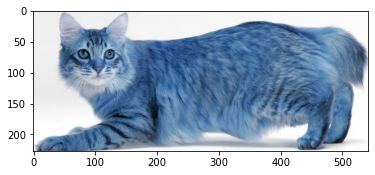

In [28]:
result = []
imgs = get_cropped_image('data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAQDAwQDAwQEAwQFBAQFBgoHBgYGBg0JCggKDw0QEA8NDw4RExgUERIXEg4PFRwVFxkZGxsbEBQdHx0aHxgaGxr/2wBDAQQFBQYFBgwHBwwaEQ8RGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhoaGhr/wAARCAF8AoUDASIAAhEBAxEB/8QAHQAAAQUBAQEBAAAAAAAAAAAAAAECBAUGAwcICf/EAEkQAAEDAgQEAwUFBQUHBAEFAAEAAgMEEQUSITEGE0FRImFxBxQygZEjQlKhwQgVYrHRFiQzcpIXU4Ki4fDxGCU0Q2Nzg4Sywv/EABoBAQADAQEBAAAAAAAAAAAAAAACAwQBBQb/xAAwEQACAgICAQQBAwQCAQUAAAAAAQIRAyESMQQTIkFRBRQyYRUzQqEjcfBSgZGx0f/aAAwDAQACEQMRAD8A+3kIQgHITUIB90iQJUAJyanIBSmJyUiyA52SoQgBCEIATm+aE4BANGi6X0SWTggFSZLlKnIBtrIQhACEJnVAdNEiZdOugHWRZNBulQAluk/ypCgHXSgpqEA7MjdNS3QCoRonIBuVOTU5ACEIQAhIUiAchNvZLdAKhNzIzIByEIQC6pUl0XQDglypLpUAlkqEIBLJicnIBLpEJyAEIQgGpySyRAOTk1qEA5CEIAQhCASyVCEAJClQgGoTkIBqUJU3MgHISXSoAQhCAEIQgKtLZKhACWyROQDLJU5JZAIhLZIgHJSm2SIAS2SpwCA5WSrplSWQC5U8Ji6IBbJcqaCnAoA2QhCAEJbJUBzISEFdU0hAcuqLLpZIgE2SoQgBCTMUqAEIR5IAS2SJboBE77qalCAUlNBSXRfVAPzISXRdALmTUIQAnIQgBDUJu6AdmTlzTgUA5CEIAS3SIQHRC5pboBUIQgBOTUIByEIyoAQlCVACEIQAnJqEA5CanIATUIQAhCEAIQhAIUqanIBqW6RCAcm5k5CAahOQgKtOTU5ACUFIhAOThomoQHQ6hNypQl3QHO10tl0skdugOY0TsySyRAPvfZKmtS3QCpyb/mShAF0qSyVAAKcmXTroBcycmXS5kA5CbmSXQCuTUXukugFQhCAanIQgBCZdKCgHJl0qEAmqAnpNEAqEIQAhCWyARCWyRAKE9NalugApE5CAahCcgGozJyb95ALdKkCVACEl0qAW6RCEAIQhAOTk1OagHISXSIByEIQAhNQgFulTUIByE1LdAKmoS6IBEJyEA1CchANQnIQDU5CEAl0JUICrQmpyAcChNQgHJ4TEoKAeCnApl0oKAcnJL90qAZZJay6JqAQDRIn3TboBd0oTMycD9UA5CbnSg3QCpLpUzRAOvfZF1zulQD7pl+iE1AOv3ShNukQD7oumApboB10mZCEAJbJUoQCpLaJUIAQhCAWyXKgHul0QCZUZU5CAahLolQDUJyEAIQkCAVCWyLIBEIQgBNTklkAicksnWQCIQhACEIQDkIQgHIQhACWyVCAElkqEAJLJUIBLJMqchANQnJLIBE5CEAIQhACEIQAhCEAIQhAVIKcmAp10AqEl0XQCoQhACeCmIQHS9tU7MuV0XQHW/dGZcrougOl0XXO6TMgOt0xJdF0A9Ldc7ougOl0XTEl0A66Lpt0qAW6RCEAIQhACfdFkiAc1OXMXTwgFQlKNkAqEIQAhCEAJLpUIABRuhCAcNEZk1CAfdKudylugHXSrmnZkA+6AUgKAUAuiRCEA5CUJEAIQlsgGIT7IsgCyLJcqLdUA1CchACEZUIBQlQksgFQhCAEIQgHITU5AJZFkqWyARJZOskQCWSoSG6AVNS2SoBNUqSyVACEIQFG1dEwJW7oByEIQChKmpQgFQhCAEIQgBCEhNkAqFjcR45Zh+Jvo4qV9UY/jcHBrQeoudyrrDuJaHEAwZ+RK7QMfpc+R2UOcbqyfCVXRcIQhTIAhOQgBCEIAQhCAW6RCcgFskVBifF9HQcxlIx+I1MenLgtbN2LybLtgGNtxiLNkfFMNZI3aFl/Too8ot1ZPhJK2tF2jKhHkpEBAnBKlsgFQhCAEISWQCoQhACEIQCWSoQgBCchAJZIuiSyAbZATrJEAJQkypQgFQhCAE8JieEAqE1OQDklkqEAISFKgGpbJUIBLJUIQAhOSWQCJbIslQCWRZOCLIBtkqE7KgEslQnIBqE5CAblTU5CAahCEAIQhACEIQFNZFkqEAtkichANQnIQAhCEAIQhACg4vV+5YdUzjV8cZc316fmpyo+LXlmCTWbcue1o+Zv+i49IlFW0jz6jpfikk1keS4k9SdSpwiFrs0d3DQbqO+R0TGtya+eiaKtgFpA0E/g2/NZD0mvo2PD+Oyf/ABcRa4Ef4Tz1HYrULyynlMuXJMCQbtGaxC1+BY9zH+6Vrss33SeqshOtMy5MXyjTIQNULQZRbJE5CAahOXCrq4qGB81Q9scbBckoB1RUR0sT5Z3tjjaLucdlj6/HZcYDoKZzqekdoTs6Qefl5KoxnGJMdqGZHOjoo9QzbOe5S0xLMoGllmlPk6XRshi4q5dk6LDoYoLRs0spnC7ORik7N8zN02nlbktmddWGBRWxCZ+X7mh+aJK1RKX7XZqLIsndEi0mESyVCEAIS2SIAQnIQBlQhCAEJyEA1CcksgERlTkIAQhCAEJbJEAIQmzSMp43SzvZFE34nvcGtHqTogHIXm3FHt14Q4azsFY7FKhm7KWxaD5vOn0uvHuIv2ua2PO3h7AadttjM50rj9MoWaXlYYOnI1Q8XNNWon1Ul2Xw5V/tT+0Soe9sVNS0wG2Wltf6qqP7SftVe28FTQtkJPgbEwvt6G6q/W4fst/Q5vo++UL4Xp/2iPaI+IuxCtma4bcunaRfzACusL/aT45oyx9fya2E/wC8p7H00H6qH6/FfyT/AKfmrVH2g1OXzJhn7WccZY3HMB0vZz6aUj55TdbjDv2mOBsRY0iaphk6scwG3zBWiPlYZK1Izy8XNH/E9jQvOKT26cE1lhHiUrL9XRafUFafCuOOHsaIbheMUUzj93mhrvoVbHLjlpSRVLFkj3FmgQm5xuS0f8SUFp2LT6KwqFShKhACEIQAnDzTUIB3khNzBAeEA5OTQbpyAElkqEAIQhACEIQCWSZU5CAblRlTklkAlihCEBSpyQJUAIQhACEIQAhGVOQDUJyEA1UPGAd+5HvGuSVriD21WgVdjoiOD1hqP8JseY/Iiy4+iUXUkzyisrWxgPLohcdW6/UKnk4hoon5SGSv3t4iu2MPhifyjFLLc+EB1iqcRvjJdHhkWUbmVz5D9Nlk+T1dVsuIMdZU+GJuQdm2P9F2kxWWCNrjNzWRkHpnj6XHkqOXF6xjLe7RMj2AaxrAPpdUWK4hVVobHAx7ajYAuFvk4baaqjLJRiyUI8mezYB7T8MZFTU2N1LaWaUlsckujHEbjNtcX+i1s/F+CUkAlqcTpYoyMwvKLkeQBXyPjeMRVGH1GG1gcJWkSatsQ5ugcPrYhecYzVmgomOkr3iWN4uGO+K5/wAP16LJj/JSXtcbZZP8fGXuTo+8h7SeE72/flL0/F1+Ss6DifCMRZnoMQpZx/DKLj1G6/OfGOKK6OsfFA7K+zXR5XXve4y+uimx8UzyUb2h7myNiJMuY3zbWIH5q9edNU5RKv0MHqMj7R479teDcLxOgwt7MUxAfExjrsjA3zOHXyCzVN7QKvjnDqSsqKb3GCYuMcIeTdoNg4nzXzSI2yUjIKevZNM+MSFznaSXGpafLsvUeH8bZPh1HSUb/tqWJrAwa7blYZefPJk49RNa8GGLGmtv7PThWNi0bqfLVTKbEWX8Yc0/5VmKGeZ4ZnzXtcgNCs4qp5fkikyu3N4g7RepGVrRlcdmrpcVbJJlZoGjU5SP5rW8MXnFRUE3BIa23lv1WEoJ5H2ijEMn4vBYr0zBqcU2Hwss1hIu4DQXK0Y7bMmeoxosU5NS3Wkwi5UIQgHJqMyEAIQhACUJEIByEl0qAEIQgBCj1tfS4dC6bEamGkibu+Z4YPzK8+x324cLYQ/k0T6jGKk7NpmWZ83m2noFCc4Y/wBzoshjnkftVnpKXoSdANSTsvnjGfb7jD7/ALvpqLDIz8IymolP1s0fReUcS+0XiniWQxYniVUymJ+Au37WY0AfULzsn5LDDUds34vx2afej63xn2jcL4FduIYzS80acqB3Nff0bdYPFf2icDo7toMNq6lw+F072QNPoLk/kvmONlfSAuo4ZZHO3e5uaQ+g6BVVZh9fKHTS09U+S93ZrAf6Qbrz5/k8sn7UkelD8Zhj+92e84j+0fjFSXsw+moaQn4AzNO789PyXnXEnEuNcWnmcTY9UMj+7G5zsov2YNAvPqKHGZ5WxUEXLJJ28NgtKeGKpkbHYpikUXUhl3uHqBp+aw5PJz5NSkbYeNgxbiqZUDhuiqHkQV95L3Lnt6fW6hVnC7KYuDK7W98scTibepNgtSafDYWCON8s8oHie5xbf5DZVdQ2UvAoqa8R+8Wn+e6oU5fZbRFp6ChZHlAq3PIsTJci/lYLk+Woh+zpoZRbQEMsPW6s6bFI6ctZ4c7TrncWt+hXet4jeA3wxBvTksuP9QXU/si7sqGRVjDnkdmG7jmzEeWi7f2gp2M5LKZzyTZxa0gD1BVthfEFPV5m/bQzH4XBxy/mnVmHy1MubKJc33tGuA76iylaI+5dlS+jbX/aZITG/wC5LYHXtbUJX8IQSwfZxxU0mwPPe039CLfmrvDy3C80RLGyX2c4OHyFrLpUPfKwuliimid2gNrfJdUvoOzz+XAsbonuEEjrNOgMoBPmCbKtl4mrsLeWVc0tLUg2u5mnqvR2VGCRU7m1cUvKJ+CJzQ0H0OoUo4Rg+L0b44JXODh8M7ASPQgWIWhSX+SKW2uiBwv7cMdwSCLl4lLPBoAM2dv0IXtPDv7Q8lWyNlSyKaQjRuxPpa118v4h7M2U9W6SixT3eN5+CJ2ZjD5joO6rmx4zgb/d8RpudS8wBtVD4gOx06rUpzj/AG5md44T3OP/ALn3LT+2yOV+VlO5h6iW4F/K4/VWcftjiYM1RSsIO1n2/mvjSDGcXp6QVdJPzYhu0X8bR5HW4U/D+O6nnNbKWkg3bIW737hR/XZ4ds7+gwy6R9hx+2GmlF48PcR35t/0UyP2q051koXRgdS9fLtFxo+pAY+TUfSxV1BjXPZo5unbZcX5PKQf46C+D6Gl9qlN/wDVTW/zPCoq32wkf4cLevzsvHjWySsBOYjo3Kf5rnHPLJK4QUri9273aqMvyOZ9HF4WJdo9Xi9qdXIWuqfshvkbcaHa53JV3Te1FmjZYXZf4V4lT0FdUkvPwA3+LdXFMyakyukkyMGlt/zK7j83P9kMnjYfo94oPaDh9TkbJmjLtvD+q1tJWRVcbXxPa4HZfPdJiNNO37apbr0LuvkLK0ouLX4NK3kTfZ/5jlP1BAXrYvKde88/J40f8D3lCxXD3HlJixEUkuWbsba+lls438wXGUjyW+MlJWjFKLi6Y5CEtlIiFkiE5ANQnIQDUJySyARCWyEBRhKmpyAEIQgHIQhACEIQAhCWyARQcYp/ecLrIer4nAX2va4U5RMXrYsOw6pqJ/gZG42zWvpsuM6rvR8/yY3WCOp5uW0Ryte1tzt1AHRUIxytklY6dzZW58rm5Sw69iTYqjk4rjroql+H1DWviqXA2+Ia6X9FMGPyv8FaGtlczSQNsHj/AL7rxnm12e3w+aLw8jvaXcNc0EvHY3uFTYvV0tNDo10JNyCLHLra1ha6jT4gxkTgck0ZGZttBpvbsVTsY7EDIXvdJG0l0ZOptp/ILDkzt6RfjxfLKqtFTWhz6gtfLELR5d5L3ux1+pF7LE8WYG9+HTvp38pnKDmyudq1pIJcB36L3HBOGhWyc2Q2Zo9pGhtruOwvp2K86x3H6FntA/s3PTNdC7wuJb4XO31HQCxKpipRXIuclJ8TA4TS0OI4BDVRh1VyoyS4fGSzS1u1lxwQwYpWvpYmX1c+RwaQXBzdPncq7r8Ii4X4oxXDqNksMFdTGop4o7kiRu4aB3OtlWcFh2FcUxTYgx0MgicH+HVrwbZD/FZtr91c+mcT2jQ8L0EWesw+SRs89GeWW/fHUEjofMbr0Lhaibh9XzqYuMRuXH7xNhoLrzvg+mczCuLeKZ4c8zatxuG+NjBvp6L2jgumZxJwxBiVAGmOUEtafw9L2+qzSg3KyxzqFGopMRbkaGDNdgLj/wBSpJmaXs5dO6QyaZWxE2t6FZvlHD5/s5GyM3eDqbj9Ff01f/dmODrdbDW581txZm9Mxzhx2jT4dHDyzkiljcPvB1z+ey0eGccU8cop6zNEBZrXHc/MaLzwcUNw+K1ZJy5ZDliZltcnsqXEzVEl0jnN1uMupv53WmflPDTRS8Hq9n0hT1kVQxpifnB1BUkar5OqcXxCmjz0FfW0xd8Qhnc25HmqN/E+NvktLjmJMcbgCWoeR8tVpXn45K6M36Gd9n2cluOq+PYOKeJII8jcYquX2bOf1UOr4wrtqzEMQG1i6sfb8jZRl+QhH4Jx/Hzk+z7Nzj8SA9v4mr4pn43rxmZSV8ziB96d7r/mqUe03iegntBXvDQb5WOe0+u6q/qmP/0stX4rK/8AJH3lcJCbL41o/aXjtfT5qjFpo79pX3v8rqvxPiziOcZoMeqDbVwM+WwXP6th+mP6VmvbR9qyVlPBrLURR+rwFW1vFuA4dpX4xQU57Onbf6XXwrWYhPU5H19VNUyE7+8HL6m5UTmtp33e7nA/ibn9LAKD/Kr/ABj/ALLV+Jf+Uv8AR9n1/to4Jw8uacbhqHD7sDXSH5WFlicR/ah4bpi9tFh1dUluxfaMH+ZXy3iEb6skwO938z4CfyVfTGpjkLg7S1muLC/6aqiX5LLLqkXx/GYV3bPo7EP2n8UqY3fuTB6ekYN5Z80hA9NAszJ7deJsVzCfG+VHfxNp4uUPS7Rf814rz6mtlkikr2xlgsGiIAn8yq+mfPSV7W1LHVUINnRlwsfO4Kzy8ryJ3cjRHxfHh1A9Sxfiv941GfEa+WdzupY559LnqqObiOOn1p6SUdeY9p/MHRDI6WeJjYKNkObrDESQP8x/oudRhzLcueR3LOuQNBef+/RYm3LtmpRSWkdqCvxLERzpZHSQt3ZC0DT1Oi7VGMVmHgGko4YnPNmvmlafoAo8WDUt/HM+VtvFGWXsfQWKtpMHgngaYcshA+Isym3YXOllGvoNq/4I4kq6yEurMRhjNvEI2tYFEkqY6UMYysljB+8W5wfToueI0cFFAIzH9oBv8dvpoquindUPbTc1zIvwSN0t5dvqufFnVvosf3/WUcgffmRDXM1oDgPluu9XibsRgfLT1kWY65XNs789FHGDmCpzUmazrbv8P0WkpKCKmY33qmcY9LZWB17+hXdHOjH4fzaiXLUB2mrQxhd891sKd7KaBtoppRbUv8NvlddJ8GiIz0T2RtG8bmG48rhV1fHIw8uKVkMoHXNYjrY/1UEjrfJHGtpoqyR2TM134g8HX6KslwnEGH+8SMliOgDmlh+RAsUgx00T8sjYXPHwk2ufIXVrh/EoxCX3eR8UUT9Mj9wfQ6KSvtkX/BAo6d7I+WBmZs1uUO19SrCCLE6N4tG9wdtllsfpZTDhFKc8sb3Ov/unXHomvFVHZtG5sMdtXFwJ/NBdo5yyYYyRzsYyxzX1BfrfzsrKIYXVjLAyVptYSRPJ/JZjEaeV8bxUcrOdGvdv8rIpI5cLEUgqGy5bZssuWw+atj2Vy2ifW4RXRExj3WeF2oM7LG38Tk2iiqsKjPuTKWpL/ihzOAB6ZXWV1RhmJwGNnjDtXhzdflbRR5+HGRzvNO+VjLWIDspH0K0rRS3Zw98iu41tBFBUndzmNfnHYWIU40eFTU15Kn3a4sW+5uDSOxIBVWRSwS8qvz1LXfde8BzfRxtf6qTT0j5HtEETDA3XJLK6xHnYKf8AJX8kGpw+KnZy8LqaURONy1zg1hPz+ElcJOEm1MXOowyOb8BcHDXcBwvotLHPUPY0R4PTiNuhyuDv6FcYqbD+ffmPw+Y7sbmsfldVTimi2GSUTBy4dU0E/wBpG+MtNtHX0Wp4fqZiWh7XWbsMup9StezD6Kpj5ctXE8kWvlIP5rL4pwviGFSuqMMmbNS7uYJQHW8llljNKzKSro10FW8lnMbaPsGq9ZKeUD4WC2jGtuAT3svNsK4iZFFZ7HGRu7ex87XW84fxSPEI9fittsbKWNrlszZYySsn8mqIzQPaB0Bao89W+J7feI+YPxjxG/oTYBT61k4GuoHw2aLW9d1EZEyojzP8bB8TcxuBtfVbYxSMTbZBqRDKM5ZMDa2cOLR/pvp/JU09ZWUekdeyVn+6nYLfJ4tYq3q6JtMCAXMa74SHHI7v6FU1TGJ3vhk8Zscknf8AhP8AQqdnEPwzi0YdWMFW2Wklv4QXWHq09V9Fez32g0uLtjoqupa6cj7N5sOYPJfJdQeWx8FQ1pj6xnoR95t9iE/hziOpwattTv8AgOZnqOre3mtWDM8T/ghmwLJHXZ+gAsdULx72f+2BuORRU1ZExswAGjrEn56L1qmrI6lgcw79C2y9yMlNWjxpQcHTJFkWSoUiA1CchANQnIQDUIQgKFOQmoByEIQAlukQgFulQkugHoSXRdAKq3FYI5qOYTiEgsN3TtzMaOpI6qxuvP8A2u1NXTcLTOo5HRjXmBu5aoTfGLbJRXKSSPjv2m1tDhfHdVFgc7jQSENL2sDQ543IaLC19lLZitQfd2FzKjmWBDXkXHYtOyy2NYc2SvFdLmjkYbxtLsx9SFVsktUSPnY1xd97fXoF83Oan+0+hjFx/cet82EMDYswG7gXXsR6q7w+h97eyR72whnizPsxoA63XmFHjMFII28x1TWi32UTi92vSwVLxzJXYzxHhOC4xM+gpKzxvgjec72hpNidteyphBSb5F0m4xtH0PRcccEYIXUf9psNNUT4mNqmk5jvoevoVjsR4KpcQ4/j4opJmvpnReJrdnuA8Lh8l8w4jwVSVvtBwTAom0uHYfVveJKibPkAAJsSASDYCxtu7svR+BeIMT9mfGVJwti9Y+swGvuKGSV13RH8F+2q2uEOKin/ADX8GCGWTk38npGH1EmK8Z1Jkhii5GaNxPxxxloLS3zJVvTcMQx4mx1ZFzYqgkSOyDUWB8Q669tyoOKQHDOPKOaNtoa6mPNPS7dQ781uqNgqZA7mWszU7gW6j1WWUKlRpWR1op8HwJk+KYzhcbGyUs1EGvHQvzENc71a7/lWj4BwrD/Zpwg+hxnFaeLxucHzyhjWtJ0GvkuT8RZwhwdjHENSG5zKct9C4NADb/Mr5s9plBXYxQQ4rXVNJPiFTJd0+I1XJpqdgaXZW3IDb2yjqSrIRXOK+X0Vzm1Bt9Kj6Vw6LA8cNRVcN4nDioJJe6GVrgD2Gq7xMZSsla8Pbk1LM1/mbbr5Z4Tw+PBqzAccwfPTSVkscUtK5xaHZmgi5330N19KU2K0NXWPo63NheINFuTK8gE9wToQfJUNRhPRoXLJCyHJh1RX4/SuY5paBdrA3w37klaPEKh8AMNTC7mNFiwtLSfntZVmBAR4i5j9Sx53/RWnEdawVHLq2OsGAhzdyO9juoTacXK9iN2lWjPYq4xwSFkLGl4uGueAAsk+rE7Hxva3mjoW6fJXmI1sTA7kFz3uG0jQPTUrJVZdHUF7H8skbZb6rOpV0a4xtbJLK14p3NBaC3cFunyWXxPHGU8meVrCzudR+amxYo2WflyC3Qkbn6qlx+mbPG4xZHMdfT4T81bGpEmuJY0lfRYgwctzYwRqd9fkVCxHDJ3va6ifzI3fAWvzD6FZLBycMleyMxMIJ8Mlzoe61YqIauJoqW+6yN+F0dywn9FTKPGVF8ZWrO2GMqxA7O1sxGmUbn8wq+TG6j3t0MsLYyQRllaBf5DVVtTV1OGV5u90gJvE7LcG/e2iuHxRYiyF87+VMNS7TbyNrqtx49lile0QJcXpw8U9fM2lc7Zrm3HyO6mSiCmaySnzN0uHscTr+YUPH8KEBhfUZaiF2kchbex7ErnJIyCIQgCJ7tGtc27SPVdpVoblosJayaeA8ypbINyQ0g2HewsoNNjr4xadrjGDoY22Nh2tquE9I4Bgkbyy7Zzb/S4UiJmc6zysA/FZ23oupohW2SBV02ISCSlLJbalouHj6DVNq+ZUSB88zyG6MboCwDt3UWoq6GMudPle8aFzdHflp9VIiqGmJnu4e4n7haWgg+ZvqrNlWhYKmqpDzGBtdG06ODiXj5XV1TcUOng5dTROm5mmrQSPQjVVtTjFPBkjrWclx/w3/o4BWOEQOnewwPaWyXsQ65v5dVyWuzi2mOFI+I86mlcwm2Y5nXA9FaR1NQYgyOZsjurJLj6Am35KHX8J1Qk57JG6auaXuzflorWgwuMMbG8ujmcPwix9Soy7I2mrZSYhWVkcljO+EAXy8jMPqOip5K+pEokgeyeQdm20/wC/JanEcI5T3MkfLym7WfqPOyoPc6fDKgvL2sYd3udbf56I0TjJGowLEXzjNOGRuI2FtPLVWYqWySvbTnkP+8x259FRMZF7vHLk5TztIcpYfUrhUYi0604bHUN/j8LgP5KLWtHNN7NbQYjTB5bVzO0uLDS3kRZGN4O+qoxVYO9tRG3Us0Lvldef1mKGrObmvZUx2+9Y6diFOwbiSrpyI3yOkZ2k8Lvn0KR6EoPtM6QYdTyP/wDcI8hz7Ob179bLrivD8UrI5KNrRNHo1zNCfXofRS8RxAVBF4Wjrc+IH6KHHiDKaQEP5YIsWtdfTzB1UW3ZOtHSjfV00QZI7lSgeX9QuJxuTn5a+JvkS3f0sraWejq4ByHZzr4i3XOqV+Gcx5MrL5TqwNOoPbzXeyKLKOiOKRAxSthsfDmY0kfquNfgkOERulxGvaZnHS72uJHbKCutFWR0b7wBvJ2IkfsbbWOxUXFBHWzs8V76kyuBsfIXF1px1RRO7sXDMRipKgNkY73d5uJYnFoB/iA0TeIHxV5c2mq5aR+gMheSD6WCZTUEU4kiZO3QWAa2wB8upUE4ViMTHB9XCIwLNZO8scbdiFevtFUu6NNwvhdI+LlVdcyuYdg7r5FaDEeH8PMQJiigA/3LH5jbyBXmtNj9RQScpzKeod2D2i3oRYrY0fHkAipmYhIynYL/AAOLTfzINipJOtlc38xZd4Rhnu1uXh0LKYjebNmPnYlJU1GF80xT07oyPvt8ITYsRw7ijLA+ie5h0E7Z3DXvchB4DdRfa0hZV21yVDQ/fvdRpfAvfuIX7voI5DNBWPN9rW+imUuJ0MRy1EzwdtXC38lArMVqsILY6nBKXlN3Dado18rXS0PFGCTyNFZgtK0ndxgBt87LLNxv6NMVJr7/APgvH+4VozQTRFxHRoF/IkJaenNPK18bMhGvhuiXA8MxSMVWCNZSy28TWNs03RHh1dh72Nlc9zeh3H5ql2nZOk1RfSVEr4mmN7zaxsLXt81xqc9IY6mB943nK+zbjXa/8lG95MDfhcCN76rq8snppWvymNzDbex/8FboS5I8+UaeyPJOOY+KfM3OdDmuCf6rL4++SjkEuZ2S+Xpv0v69FYPxM09T7vWZhmZ4HHa4UPFwa2iNtHG7JWHUbXa5t1O7JJUzL4hOZ5GTM+0ZIzMHHfTQhRa+mIp462nzODDlkA6WXO0rKedxzARAG3YO0uPmuNLipFHXx1GUh5GuxuBa/wA1dHaOS0Ow7imu4erPe6eT7N0gBzNuy/S/4b919c+yD2kR8SUkcVR4JToHB2hPZfBNZiLow1r3OLCcjmnYi+hX0D+z3UuFZGaOb7VludA/aSPo4HuF6OByhKvsxeQlODfyj7eYbgEJyj0hzwMd3AKlL1TyBqEtkWQCIS2SoBqEZUICgukSXSoByE0FLdAKhCEAIQhALdF0iEAt15p7YZ5GcPObHs99negXpS829r9Q6Dh+bNlMZ72Gqpzf25f9FuH+4j434huyV9nWeSdR0Xn2KzPZ9jTOzVB8IA6LfcSztY9783MO4a3XU+igcMYJJnM5gbLJJqczCSQel181D2n0c1yMLwpxTVcFYmZKuj5ud9359SbedivWeLMHp/aJhdDjPCk3JxSieJIg5tiCNSHDeyqOLOA6nEaczUcLZMgze7O0ff8Ahd1CxeBV+IcN1eak5tDLezqd77SsI3uDuOy0yXJ849lEX/izQnH8To/tMT4VqxirBZ0kDA6N52uD0usdjtNxRiNbS41ilBLSRQVDHQwn7uU6En+a9ywP2l1VaIm1NKyq8F2uliAuB3IVT7R8blxxlNR01PywbczltsBft6KiGRY5aiv9/wD6W+jy3/5/9HoElXQYpR4VWTzNfIKcNaI+7gCrjAKgU0nLlzygDMHN9fhNl8/0+KPw/lU7J3CMSFkbi65sNF67w1idqFjQ/ObZi/z6rFPJkcrNi8eCiXvtYrf3n7PIaXh+ZgfPWNGTKMwcCDYj1C8TfiM8FFNhHGmA1Xu0YDWnkGWKUC1joL3utfxAZsTrWUtMeU8TtkbbQB+tivR6Ti18mEUjqvD2OqmM5cxkYBqBq4d1KOd5Eoy+COTxowjf2eQcHYHXcacS4XV1FBLhXDWDv515mlrpnjrY9FsPaLx3hWM1H7qw9rZpoTeOYO8TCOxspXEfEE1Xhk3uc0Ij18Gfltt3O30VD7PuFJ63EGTspqWektmfNC3MB2FytCdlKjxLngrG31kUj6iZ5rKewd3LR6br0XE2RYxgYqfF7xT7PbvlKxGM4VBw1xDBOwRQiUWeG7kHyC2mCVMAjkpZC50b2EWDehVDVTaZOTtKUTDVL6lhysfmP3rtubeTVR4pVsDmMjexjshzjL/XVaTFIvcqh8VPUO5TX/DNAdL9nBYnjN8ktOxsVQy/Q5bkAdnFUxhumy5S0VUcsL6l7mVLX9Da4se9lFe90j3xDK8nVpzbjooWD5ZQ8O8R6nufVNgovd8TcXFxYfiaNbHuFbpWT3IpcUp5Yq1okh5ch1a8O/JX2D1coDIpY5SRpcWOnYtKk19O+sphnbcA+F3VW2AshEfJqcj5Btmbuo5Mlx2iUIU2Z7EYoZY3vp8sdvj8JAI9Dq0hd8Hkilo3ctjZmM8LrWOndX2NUDIopH+7usLlzR4rDqQsPg9G+LFH+4PaST0dYPB3BGyrVSjbJq7o0FXkY/ksfzICL8uXXITsb9lBnAyMPJcYur2NzWI7joEs8kUmJvYMwc0AljujuoBXSOpjjrmRc3lPcLjLoP8AvuoEhxrL0hikc4RE3Y4t1Z2ThVx1tOYjHDp4Scx363UmenEAlfLE58NiZBlu3/v0VHRxxsxF0MDnxl+zehbuLjqpJasr22SqigDAyQs5gO5zbjvfdWGH4XUSvDRlkjOpY5ttPqpNFIyJwDw51jlPldXeDVsEc8sTxe4Ivlvl9Qo7bF0jKY5gBkL2+7ueelnkKZwvE3DC1tW9zRpbNe60+KsjYwOkY2SLYuY6/oQVGigoqhgbJ4e172J7eSuu9FPxZNr8QpywPZU8onYudcP9HAaHyK44cKitk5Je4RnqXXvfa1lQV+GSRxyNY9uVz7Pjbe5HQ22NlxjkqMLDMjnyNGoI3FlF6ZJbga4YJX0xkjnhbURn4OZobHoCFTYnhU7A9hguCCBmdm+WytMH4olqHtjldfMfiPX5FX9RWskZy6pjjCOo1Nx+amqZQ3KPZ55g0k8QNNL/AIA3jLrgfIqwrMPpjG402XS1h1HorCspIoJTPE8GMi7SHC4+fZd6KCCpzCeJuUjRw0Oqj80W3asyXujHzxZ38u27XN006gq8ZSNAHLp+dHYXcNVZS4fSQSMFRHfKdHbWKrq+N8FTH7tJyzawtpnHcdFwKXLR3p8LhnL5qZ74QOzut9spULFMOjDM7HZ5WC5Hwvt1sOysIo63wuBbmGzupJ6FSKiSCsjBqYbTsBBGXUW7Kv5J2zNUOJwMHusgc+N+jt8w+atqOMQXcZnSNIFru6bAkFUslI19S9wzOyai7crtPLqulTIHmIMY8DQsdm+910/RSStnZMnyUklO+V2fmAnweIHfXW+q4iN07yOUyoI1yyuyj8rK0oIOeYzUwuAGudzbt17KzqOG2VP20E00QGoJbdi041ZnnNR0QcPqgymcyZzabYW6jzBI1C6nh84rJ9g6KeI7v55AB7hoB/mphkmoqctjew5NLO0B9NOqqA/F8Qe4wZ6B5OmaUWIHYdFZbiil1JhJwXQEkPiheW6l7XXdcdB3XKCCPDpOXR0TJQBuadtgfmFKqBPhkbXyS82oPUan5AaKBDiOMzyudU07Yadxv9q0Fx9Qq3NtbLIxrqjV4XxrBR5qavoYohsQGNYb+g0V9T1dHiZz0dQ+GQ6iz9LehWYo8Ow3ES5tbEwyO2bnIB9ArOn4Yfh4a7D35Muojl8VvQ9lxSdEJRjf0y1LKvmvjlbTVTWi/wBo2xI76rvTRUFQeXX0DI+mjLBQ3zyRRWnZme29zl1afIqTTVLnsBeGyRm1iN1Bs6kTDw22BnNwp/L7AO09EQYpLT2hxGG42vvZWdARszMD2Uitwg1kRsxmf/LYrvC9x0OfxIoamNk4z05aQeg6eip31LoA+KVlgbgW016fVSK+nrsOfpE6w+Y+apq2c1Bs8ZD3DuvQJFtM41ZDxe88LXRhznAZmg73G9vUKP7z71RMcDpJ4XEaWFvyspskoD4436gg2PcHcFVlNEGSTRxfDIDpt4hsrl2c+ConZJI2SLaoadez2kWPyO6zNJJGyomjn1jIMbr/AIxsCtq8WnEsYvZ5jf6AD+qzNbRGKrqXll7kmT0HVaIsqf2Yisw8zwODDeWN7nNt1F7gL0v2MV9TTVtNWUWYuifqPK9is/BQNzyOy7EFp9dF6P7I8ANHWglmeKR5uR57rZB8mkZ5Kkz7ewCsbXYVTTj77ASOx7K0Wa4ODosLiif90W9R0K0q9s8R9ghCEOAhCEAIQhAZtCbeyS6AddOuuWdOzIB904LndOugHXSIQgHIzJqS6AV507Lyb2sYfBV4e/mB7nAaDMSPovWDtosHx3ROno3tga1hIN3He6pzLlBouwuppnx7U4fV09R9vTv9zvbO2zcmvorirrDgkVNJFPKQ4Gzm66fqrnGMMpoat8eJ1EOd1wc050B/hCqJMHpjHBB+8GvpY3/ZlkD3loPS6+bkpLo+ii4z7OuA1knFbJIqipqIcp8EuVtxbsLJcQ4Ckkzz1PJxu+kbxAYpWkdcwJBWzwDD6amYPcHS1T9zbIB8+oW7p8PhnpHCelZCXD8Ze76BbsUOcXfZjyzUZaPCqbheDCMOfUU9Li1fG14DuVRl9iejSNTYrrQSYZi5/dklPLhlWC5kzcQa5khsAbsuPEO69Pr/AHeJ+TDOKpqHlWJileImsaD4tAL67LP0+FYtWYi8nirD8SjjqCXR1kQeGROFsgda97rFPByZrhnpUeKce8IYhwnitMHsY/CLmWDEN47keIOt8K1OAPrZ8OhlpX080UgFpY3eH1Fl9G0XDTq/Bv3fjlLRGJsYZePVpHax2Xg+IcD1PDXE7+GsDYyPD618lTFNnsyFrgA4WG1jsAtUvFqKaR3x/JhKTjkLHgThjEuJcfa+PlVNJTn+81B0bEwHVt+ruy1+OGuqcZqcN4awRuP0EORrph9iI7gk+J2j/kvReG6Cg4X4XGGYXPDBeMgyObmJNtSQN1gpcDw01sNRX4zjGLBkbiI4WFkbGuO+UW06KjN4kYJNd/JGPlPJJ/S6Wysr/ZnXxyQ/uzDmXl+0kZXMzsiJ1zNAPi+qssKpMW4Uoqn39lLcA8ttN4WX9LCy9P4fr6H92GOgbU2hjs3ntOU2H3bry7jriN8pNJJQ1GQn4mNLR9dlJxhjhzbK4znknwo447Qu4joqSpqXtjkDMxIdc3GvRVXD9aX1eZrnSNjNmvy20HkpdQ/3/CoKKgzxNyDPmbrfycF3wDD3UT7SOYJB8bXtu2Qd7jqsMlzkmjTfCLTJPEzDU07ZQXggbOYMt/Irx7G6htTI9tRFcMuC3Na/0XuOKVtPBSnxcphFyHOzNPp2XiuPxsNXUOiDZYpDm1cDbz6Lko1tksUrtGWppDTl8bIZYoraNLr+tiuYxGGmr4nPe5uY2bfY+fqpkjGRsAjLWPB0ka4gDtusxWFzJWZ3Nlpg/wAbQ3xgjW9u64o2aeVM3NXUtpslXC1s1LJbmta25B9OyKeWnrIubQFsoYLlvUDzC4UHu9fRDlZTKwXLmusHjzC4U0DYpBNA9rZtb2bYPA0IPmqGr7LbrovRUe8U8QYWvzeEtOpBA0N1lcGp4YsemjkidZ5u09Lnp6q5njdQVcMsAcYpiCR2Pmo/uj4sdkfIzK347DbXqPIlR6TQX2Jj+DzMrDWBjeUNHPbu0HYkLNSwS1L+ZvlktcW8JK9WraTPAx0WrZGFpO/TVpHUFee4nhZp3umg+ykaQBEP5f0XIsknZosCqJRE+nqW5nZLAmxH5pH8MPqouezKDC+4DfiYO3oqOgxGT3yIHNCZA05T0I0K3MFWaOUThjWxPZlMf8QGv1XV2VStKymZh9TUSudTZZHxfEwOF7dcvcFS46JlXHzj9nNHs/Y6dCoktZJHV+8UWhJzRkdurXdD5KdWSnlCvpGOaHi8rehcN1ZFXIjNtIrsRfV0UeaVzSOpDgGuHn5qPBi7HsY7NeEnc7g9j3HqpEtRHjmGPZEGySWN4S3xAjoq3B8MMtBLka6RrTYjq0+fVWdFV2jRjEI3uYDE2JrmA3PiH/hR8RpLMaYnttJcsO4J8iqysp5IqdmvwnRobqLenQrkBXVNM0UhYRGbgZr+HqpSSSIw7LLAp4WStbO9hkdcPa5u3nqrrE+dRQSuo2umhdq5ua9iPwkbKHhdNTyvy1bOXUNAOuoPmCFbwSQQScmdjmh3wEO0IPVQho7k2zAVnEJqYzGWuGurRa6vMBrzPFlpGuYW9D/RSMTwLD5XvccpN/GQ2x12Jsqujjfw9UOeG8+mJsW65gehBXXHkwpVE08sRxON0YzRVbNBm69/r0WaqaOupqiM1E7eQ42PYEHqOhV1+82yMjnEt4zYC+7QToCqTEMVdPUhzHOkZfxtLd+hUZKhDbNDHVyFjBI3O8AFj43Xa8dDdcJcbile+GWFwmABI2Ol0tPU8qlJiF4bXZ/A5VT5nVrhVRiJ7x8bTuDsbdwVU0rLUmyEZ4Kes5zJXmMC7o8t7XPmranZGWMqWDmxPOUt2c09PkVAqGRk3ghvJs5ptqE0zzCRr6aGxZZr4XWBLehF9wrYpMjJtFpFiNRFXvo43McfuBzbC3Yg9VuaB81JSWrYWvjIGjXeLz20ssHHFFiM/MD8hb4tXZSw9uxWhNS5lOA8ObERo4uAJ9CFohpmae0izeTiL5Rh8LcjN3FwBv6FUGKcPzX51TWNpidGtc4nOfIAKzwrmyxl8s8MMe0cbmEuPmUtZyy9ojmZNMdGjxDX5KTbatkEuLpFZRcOVVUea+S4YPiLSz8zuouIRzUc/LbTNqutw03+oV3BhlVUyWxSVsVMwXsMztu46KyiggFmUWIReh0v6ghVvfSLLrtnnkuNTQVAL8NdG9tjmbcH53Wmw7itk+TmRVFOe5aSFdVlRTA8ueCKR53cx19FDZX0jCWy0rGjoWu6enRVvRJNSXRdUeJw1OjJ4pHHdp0cPkVJjEUErbHKDqW7j1CqP3dhmKAOZl5nQ57OHoV1OGSwC8cz5Gt2zanTzUHZxKP/AEa+gqGtY0xzMdm6HcFXdPiDbBs7L/5dV5eHzxTfZvt3aditFhmLkNDajM301CnDJsjOGrNbWU9PVxfZv+IbHT+a884iwg07+ZG+xabWLdLeS2GfO3PTyZhvlKjYgIa2Axysc14GrT8J9FqaU0UJuB57PEZI87HNuDmHl3Cjcp0ZcRreQEEbFpH6FTnxNpJ3wFzi1xIsdfTVQomOjnc38BsPNqhFbLG9EWtkdTvqmWtzcsn5C9lDxuK1JFUgXLvC70O6kYoQ6Rrg/PfwkHy0UXGJDJhdOGP+zL9b/Qj6haoKymTpaKmd7YAICMkjmaDp3X0R7JsEaaSlmey8Uwu49Y3d1831FQ+cOa/K+XlgA+Y3+oX2R7IKJsvC+F1DB4JIg823a7Yg+S34IXIx551A9TweDlUcf+W11ZrlBGI4g0bLqvVPKBCEIAQhCAEIQgMqhCEAJQkQgOgujMmXRdAPzIJSBF0AuZOvZMui6AeSbKgxuiinie+obm7X6K8uuE8TZAAW3HZcatHU6dnzdxrwoah8rqODl/xbErG4fw3U00l6iSWU9ImaBfUmL4NBIx7pGX7Ly/FaLJI9sTcjb/dba/zXkZPHUZcj1cedyjRjqd76RjfeA2mA1DIWjMfXp9VocHxmrkJIyRUrNHyu1Pew7u8gokVAySUunbaJhs4hupJ2a3u4/kr1jIoI2ySsZHFEy7GN2YDta+5J+p12CnCNPRyb+yeMLwzEbTT0dOQBmyTNBdb8bj18m90U3DlA1xmfhFPE0jRodsAbg+ZJKhZ2mWGHm8uSQiefxXsLXa35DX1creLHaeM/3x7WMJAb4tuwVyhFvaKnOSWmcKitLw8UdDKWvfmfe4Fxpf6rHVPDOK1mOnEjM3mNGRkeXw5Sb2Xq1PJT10YEBa8fmrBlFB7wJALOta/RX8EyEcvExdLHUwRwiek8f+8DbgedlZxUeIPOeOaGLLqPsrEAb2/mtHV1lNACwltwqKatBIs+2pPZUzUUiUJSkdKmrZHTmCaRkkjiM5a3wkna4GwPcLH4nhFQXl1G6WE/egl8RH+UnQrVxvpIp2U9w2VzCYgfvMO7L+XRRcReGeHM4x2DoyfoWlZMkecfcaMcuL0YhkEsWb7Fsr9nMDcjvkO6lUcscb3OlfymD7kzSPzVrP8AavyVDNR8MnXTof6qtxHHKSkY2HFIc/4ZW7/XqsDSj8mncih4sqaAU7zTsY2OQb57sB+W3kvEsRqWmrmDIW8oH4nOLgD0t6rYcS1ETJZX4W9jqaV9pgNAAepb0svOsVIpvs6SVpE1xcO0kPl2t0CztuTNsI8YkGStqGVj8kXJH3mtddhHoVT1xYJ7HKx2e8bw64t1v5KwEFdTxMZK5hhuCxx3aSfhPkqWsbJE/K9zmEvuL6gdDr5KUdk5aNjhkUlJknp8r47fajy7juu9TVhlTyXGweQY5G99wCqzBqmegjZDUOtEdW2bcAW1sVa0FOK+vdEx1i0XJ3sf/CyyVW2aIvkWU9QTk5mYSNsHt6Zb2v6hX9TTNqYoJonXlYMpB7Hp6KjrKZ4r42zRa5BfzHX8tVdvk5cAYXdLB3Xa4uFmvZa1pE/DJOZQPieXHl6s63A6X8lT4rTCoYcmUSR6nw62OxXfCKgQVD/91I/Rv4HE2+i5zyNlrGPp32jeCxrjsHA/A5d+CFNSMpxGx1GynqqSNxcw3kb3HUhbTCquHHcOEzzkvGA4dnDqqPGYhIOW9vKeDpfp6+RT6OOTBqL3ynHNpCDzmD7nf6Kxbo5LqzlNSHB63kvLpIJbyMb5HU5Sp76scuWJgdyZwDE8dHDuPPqq/H5xidNSuonOzMs6N428h+ilYNVNngNPUxWdu5rm2uNtD3BV0e9FM17dmXhkmixGWOR2huYy11hcbC60OEMmppG1DHOtJo7z75vRZDGYpcLxyaMuc+mk8UZ7O81psOredBkv9o0Dbe/6gq/j7rKeXtpk6vqXxZmyeEnUeG402/8AKrPfMlQ11Ofd5Sdb9zvr5qw95JZ4w18R+45tyD5KJLQRzvvGLjt1C5PqjkXuyzfiD6akbU+7OmY0gPMbvE0HrbqF2ZjkOKHlVLc0YA5cjfC+O/cJkVORROZ4mSZLZmtvcddOoVTw+9kdS2GshaxzT8TdQ5t9x3CrXtRY/dI0D2c+NzpHuGXd3XJ5+Sq53tie+mqPgcCI52ageTh5LUSwMgj58T3csWDhlvoetll8ZHIe6IlrZow17HjZ/r6hT3RWtsh07308RfI/mxuAabbWJ0I+a7YBTtqqh0rnONgXWNtSBrf1AU18DGU0JMeaIMyys8jY2+SsMPjjp6Zj3xZQYyRJl7G2tu4VUtqi2OrIUsraZ8sWV13atBbZrmka2PQhcsOw53MfJILgagHRw9SpNXGypqLSRsbY3Dm31B1FiuM9a2PNT817H7WGjmH57hQqyd0iRUGKbwxMY47l23yTI6dlTGAImlhux0TtHNPQtce/ZPiopp4/Hlme4aS6suOl+6fHK3ninYYppPhJDtL+dlZHRXJ3oSPhyAHme/skazVzQ8syjrYdVAr6iN87GDmmMHYOB0+W11qaija+BwkfFJIwXPLtf0VZw9JSGpfUVmWQtJETWxNAB8ytH8FCl8l3hzMNNA3+7THKLmRzidfIFU7uKaUVLo4KPn5TlbmfY6diLWUzinG4o6RzTE0l2kbWdT6NKxeF1MUEvMqGOzOOxYLn5BSkqRGG2el0WMYrWtYIMNipKd2hIdc6eu67YlUU1NaONrveTq5uRriT332WEqKuvxR4Y+RghabsiZKQQPkQp9JBFQZZKx3KY3VoD81j59So8vjscFdstZ8Ilxh9szYPNjv0UeThatg8Ir2zAC99L/VSGcXmSPk0dM10VrGV0VvpbVRpWRvzyGp5Tt75soH1Ki9qiatbCOgqKd7RnvboFPjrKmMuBp5X37O1WSqMZfTPLY6t9TI3/dxF/wA7hSaSvOIxtdJPM+/QeEfNUOLjtl6fI0Xv7nkCSF4F/vWJ/JWNJOwn4H2vfqqSmjZEA6mDtTrd3XzuriPEDTgP1LBo9nUearXZKS0amkMZjux72uGx6FFXVvEWR73eVmfqqamxyCWwZK2x1F26qXLUNqYixhs/+FbMclVGGcWjN1IjnqHZHPZN8QuywuPNMdG5kgd9/fTsueJsnY8DM0SNN2kP1+YUWnx2MZxKxxMds92m+u9ldGOyLejhilPzGGQC1yXX9dwqqWndPRupZPj1yO6a6j53XouF4RFxHE4YW9sshucnf0VPLwvUQSywvY4EC1juD0WuOOS2UOSejzQxPkqInxZvtLtI6hw3C+7fY9Re78H0TDrlYNfUAr5dqeC5IpGVNOy4s2ceHQW3svrz2fQNh4ZojGLB0TSR20Xo+PGm7MXku0kjWoQhbDACEIQAhCEAIQhAZVCEIAQhCAQJUIQAlukQgBCEIAQlsiyAjVNO2oZaTbssvW8PisltG3I3qQ3oteWXFj1RkAHhbZQlBS7Jxm49HmWJ8OCms9kWkekce9r7k9yVRVlG3OI5ftBGTJL/ABvA2/8A8heu1FE2d/i6arHcQYG2CjqZ2C1wAB87/oqJ4q6NEMt9nn9hzKiR7rySMDSe5Nr/AMlFlw9zwzyeT/JdKZ7RUPzu/wANoNvQ2/VWRLTlA2A/O6oTtFzXFkOmq6ujki5UjgTsr2DFcRLy01Diwqkkq2QFzn5fDtdRJOJ4aZ+Z5tYAm3ddcq+TijfwakvfyqiSN+sIzPa52hAF1nsH4xixn3Soia5sE7zG2+7HA2IKp8X4oMEE9PBrLURXkI6XNgFjMOqzRYVLDTay09QJ2DuL3WTJ5EYukaseFtWe2YxK0Cimyt5sL3WI3sRcJklfDUmJpe1sNQA+PyfsR9VgcS4sjxOjbHBLkmjZ4HHZx3/6LN0nEFRW0j4SHxSMqCHNLr2cW3u0+ZCy5c6vsvhhk0eqVGK05p3silaZI7h3cevovKeLOIZ6YzMAa7qWloIN+vmo+K4vNRVcVZA9xMzM729CRo4HzCyOO1/vhifG53u0lyb62F7EeVisc8nPSNePEou2VsmJy1jntkLooyQXNDfAR5j9VWT4cJ6/KXfZtF2HrfzI0PkVbzwRPZCyMeI6Ajv0IPUKwiwvlMa+XUEakN2+Shy46L1FPZVnllhby877Wc02uSOoVLj9HFJFnhbfli4I1BB3Bv1VnjsToI7Ne0/eEjNz0/LqqmWe+Di+bQlrjmve6lH4Ykk0xIJHMw9pAvHHZ1z1j628wt1wfQMkghrGZTzQ4Nc3W+XovOizJRFgkvGY3Bj+muv6L072eVUR4cw2PwgsFyB5OIJ/NRyr2nIPZbVFEaipEwda1mnuCRdqiYrSOkpwyPSSI9PT9FooKIvke+L7QgEADqdwPVTJaBkxhka1pL2eIHuB2+awqL7L/USox+EU8lTSvzj7S2vfRVdA4x4nU0sozxynMPIg2K3lFh3IkcIxkjdYg9BfdZHF5WYZxRC6WPlAkMe7pc7FdUahsnzuehOI8PkNIyXNd7bZXj8PUHupOCRCSgmp6htmSjb8ei0tRh4qaOSCV1rX22IKz0Ub6OPlSstkNs3bz+auSqjPy5RozVBlwzEGUx8dK+4aC24LTpt5K8qYGwaBti0/Zv6iw281BxPDufK6SI2eXh8buzj0+akVNQ6vpocmWORmjh3t+qtgrOZG0kY/ihkklTHUP1p3Cx7i29/RcoKeWjAmYHSAEEObrorarZzSYS5p18Ubv0KkYe8UYZG+PmQk2sd2kdQtCezO1osaSelxOIZA17hpbYrsKTlZSGtkjfcOy6G3Q+oVPLGcIr80WlNIeZG4fmFrXsE9OKiE9ibN2J7hHVtHNpJkAvlEWePXln0Frakeqy1Ozl1v2esZfnbfa53stgx/uVY2OcfYzC7O1+ov+YWaxLDH0WMO5XipnEujI3aDqLqElosi9mir5Xy4fDNTvyEHI4D4bgaA+qztZP72Y4yzLUteDl3D2nW4KZV1NTh4f8JDSOY0ffadWuHyVlglB73W++SMvDTi4I+9ewA+pXXpEF2WkUkYp4aeoc2MuGUO+Vhf1XWry0dEwve2Nou2x8xcfI2UCXB31dTLMczI2g2+RufzUcYm3EM7Lc4NBaGu0BI0/RZqTdmjapHCsxGCnZneXQiQZopWuu29v5KLRYhUVkgMr21AGgkygXA7pK2k5jHw+OMNOdjTuHbWsolFWMw9+Vls8hOo22+imlfQvZqquKrZQZ8PlZHFs8NcRkP+U6KHgc7RWGnqMhkPx2bYE+fZV8mMMjpMr3ua+4vld/MKXgcvLErpXtfFq7MGXcB5q6rVFHVlpxKxjI89G+ns0auZYkH0GqruG6+nZG4wPbLLfUFjmg/VZ/FY3vrMlHI6ON/j5kLSTbvlJ1HoVLqMVo8Iwh0dXXMmktcn71/RXpW0ihukR+IcZNTiBjnle1gOUCNgY0epJ1+S1eDUEBw4PkqGyN0+J7QTfsSF5jwnh7+IMbfM+endTXuNyAvVzh9BSR55cRYGMGoLDZnpddyKnSIw/bbHmgig1pmwwk/CTKDf1IVWKeqqJH+9tYKZp8UkGt/zKzmJ4/8AvCofQYfUvyNFszKduY9jmDktJE7DMOzVFTLe+uZ1rnuRdOHE7ybei7q8dLH+7YRPFDbQySsa23nruq79zz1hD8QxWHEHnXlyMDRf5FVzMRjq6hzq9kssG3MERygjuQLq+gOFPyCKjbMNwRLpcdiNQq5WuicdvY7OzDwxs8MtK8Dwvb4maeasaSWDEH8yKzZhrmb1tuCFHOL4TLelkkqKKcbxy6g/5TqCmUWGN5/OwydjC462+E+uuiyzTRrg0y9o7Sgi7fMdD8l2Ilp7hhz2+B3kob3xsY7XkzsPiPS/muvv7jAYpfBIz73yVCbRc9nHCqxr64CRnhvZ3/haur5NMW8t1huCdQQvPMQqzTUwmztbIJPjHXyWlZWPxHD6aZ7M/gyu6ajstsH7LMeRXMWpqTK9xhYx5OhOXT6psXDnPMT5ZnMY0H73ilce5/CFIpoJZGZ2P5WosA25I+asYmSy3IDg0bOc7+YXVkcGQcLKHhbGajhriiFkD3EMlH+VzSdh6L61xLgqCuMFfFE1hliDnNHci9l8i4xRup43VTHWMUgLOhcvtH2bYrFjPBeFTRSumywNje93VwGq9vwZrJFpnk+ZF42mjMP4SZTxsMkOaMHVmX7pFnD9Vt+FKc0eFtpTryCWNcOrdx+SuJaSKaPI8aLlRxGFzw5tnbEj71tivTSSPOcm+yYhCF0iCEIQAhCEAIQhAZvImli7ZUZUBwskyLvZJlCA45EZF2yhGUIDjkRkPdd7IsgOWVGVdsqMqA45Utl1yoyoDjlS5LrrlRlQHMxqDieHtraYxFtwdwrLKjKnY6PHcb4Hkoc1TTahty8d7rF1FZJQR/3htiy976XK+kKimbURFh0uvJeP+EzyHPpmOIbqTlWHNicVygbsWVSdTPKanE31Ydkdq4+Hw7+g7LKYrWFmI0lMH3u8F530BufzV1UUktG+UlrjKdAT0HVZ/wB0EmIGeV1yzXKOw2XzuXLPp9nt4scO/gn19S0T23LdHX7Kq985Ief8MGPJfqRr+S44vXMo+SCb1MpLiOzRrqoeH0k+K1nvM944XbA9QCscpM3wgqJMEc2IZeXowjppax6K3jlZSUkzJH5ZnyhzZOzgxc6ipjoA1lJluNCfIrO4rXmONjZTYseXkjX4tBcei7GLu2JSVUujtWYi6rEsb8py+No2ObY29d1Dgp3SRF233j012vr32K5seKhmaJnw6hzu3kf1U0R3LA+VsYOrXN3NujuhVy0VdnHDKMVZaz4YgdW5c2V3TTorfFGS0eQeGSOwP0U6jghZkdFljlto+LTf1XesidUxZjI0StFnXZpf8Xl/JRe3bJX8GJxSKPFYmmCV1PLGbkNb+dvPqs/O59NRzxHKXvNr5bscSd7dFeYjJJR1kTpadr7mznxOsdeotoPRUPFFYz3N9solBNu5IN9R0VsI3JIhN1Fsz1fWcuokpnscBKy7Wjoew76re+y2vbLgz2tNnRFzXB3SxG3zXkNXWe91ZqGPdawLT5j+q2Xs0xOGmjmllLSGyEyD89vktGbH/wAZkwz957IcYmwuVkRZ+FxI18QvdW+N8Ruo6CHEY42vax7TIA61r9f6qojDMcw5r6dzZJI9GkbloO9/RaA4dFWYZNR1MLomysyEFt22ItoV50eSlxNc+LSZZ4ZWwYpAJKZ/2hFi3oW+fosZxzhBrA57822V7ut+/wAt1O4PjfQVfu0pu+E5TbYt2C1OJ08dQJGPbuwtsfNEucf5ONrFk/gyXBeOPxHBOVXnNX0TzBUD0GjvmNUuJ1EdXd+W1iA8juNL27GypRzuHsVFbEzwv+xqmfjA+F3rZS3SXlMkAzxNJOm5YdV1vRJQXKx8VG98b45DeNw8J9NlR1jHU5exm+5B3PmFpquI+5F9IXDq235FZepxE18VqmLkysfZw217jsVbFUrI/uZyEcNZE5x+0OgPr6qdh9OHvFLWMa94FmvOhc3+oXHC4Bd4AbIwnXoR5q0qaNz6dhBuBrFKOhHf9Vanasrkq0ZnGaYgtpp3vB1FO86X8j2cFccJ4lJU0hpqhv8Aeqe7XNO0jBtbzC54jB+8YhzPBMBqP4h5+a5YVJIHieQZZYj4yPiFuvyUXLZPj7TQ1JiMFsrpA3VrTuB1HqFTzvZpFI/PGfFG8fEzyV1WuZJT8w5S8MJJbtobghUNWAWwPDPC5hNxobW/mFNlSKLEJJZ6mGEDmSmUQkDsRf8ARejU8TMOo6eGna0FpDiOhcTosLw5E6pxmonlzF1OHFnYm1gfzWtpq3wUV/Gx8lte4NrlQyS1SJQj9jcVxmGjjrIIG2bES0O/GQbH81j8CoHyR81+ZjHSXI29Ap3G55Ejmw+AySNb9Tqu8rxRUkJgGhADm9bG13fmqmXxVIhY/WxsPjLjIDlY3u4Da4VPhdBUYvUsrp6Z8IIyui3AtsRZSpo46zE88GaSlJEZb0FjYELfYXgbqZkLIHuDSdbu0IP6opUqRxxS2zO/ucV5ZFBGwfj5jb3spWIYW3DIrQZYrC7gNHDsQVp6jCG0fObUSb+Jsze/TMDse684n52N4w/DKibmNjOoNzkvsWuHibfzzBaca+zNOSfRY4FQV0kplzMqGNNwZGZD8rXAP5FUnGGJxVFQ2gghbC9zwHNddoP+VzdPzW3xAVWD4Tyi90sbBYFtsxt2cNj67rIU+FwV7/fI8SfE0G5ZNERc9sw2PqFYmlsqpy1Wi84cpKWno8sEbWygDMQ0fzKyvG9bPUVDMOp5oYoZD42teM/zJ2+QXo8VOcPwh5YxkmnXKL36ghYePhiWpxF+J19Ry6dp8Aa24H/FZQhNRdsslBy6H4PwxQ4ZRseymyyW1eNQbqFiU9DTvlkqIrhuxLrC/puoXFPErp52Ydhb65kTdHvLXC/ztss3T4fiGN4q1sVI+WniABe55t9ArUq90mV3b4xRdtxmevkayny0dM7Rud1ybdrprMU5VT7vGZebu2QtG4+YWmg4aoxEP3hCzazrMsqHEMQwvDp7Szc4M+F/3hbv3XFPnqJ1w4fuZbxYZPidOyWoOaRhF77+nr2KkUlPU4fO7lvdlabH9Pmm4RxbR4nTuhYx1NLpd562NwfQpj8XiilJM/MlJy2HUFZ5Rk9M0QlFbL6txDlU7JqnL4gWuPU9lUU2LueXRyZSdx3t8lQcQ8RyxssIbRw3flO/kqjB8Tr6meeZ/wBm2wPibq5x3tfUBcWF8bZ15VypGjxTETVVkcVmsp4jlDjuSewXp8dM6nwCjbE50N7Egtv0XlWDx+94rCy7TI541GoGuu69UxGOQ1tO2OT7OFgaGbXPorn7MbKv35NnanlFPG0vdmeRoRoFa0VZG8ZX6g72WMxGo5VTy3l/KYLjcBdoq9942hjmnS1ux9Vh51KjS8dxsteL4He5wub8D5Q0N8iV9Y+yGlbR8CYdGzbxEfVfJ9ZIa400JzFsbwXnzX2RwLQ/u/hTC4TqeQHH56r6L8ctNo8HznpJmjSWG6VC9g8oEIQgBCEIAQhCAEIQgKgxpnLUrIkyICJy0ctSsiMiAi8tGRSsiMiAi5D3RyypWRGRAReWUctSsiMiAj8tHLUnIjIgOHLRy1IyIyICPy0vLUnKjKgIwjUatoGVUBjkDTfurLIEZAgPmb2i4AcKxCZ1skJ1zbBeM4vi/u2aKkGaok+mu3yX1Z7aMDfiGB8yPNeM30XzQMEZSSGoqW53/db/AEXzf5DFJZPauz6DwMkeFyM1QYG95dWYvI5xcRa/UDYLrWYm90pipm5ImkNFuwCm47USP5MUQvK45WsbsPL0HUrLY5iEWHx5A9z3Bh1bpe2pJ8l5axs9X1L2x2IVbpCxoe0QmQZru6EX3VPW4vHIyaolN5A8BzMuzdhr5LL1lRieKvhAc2ngdFmdI74d7+unoueFVeH02IsiNW6omkIDj4iwX03WqONpFDypujWsrcRHKdQsc+ndsc2X8ip9IakSufGZo3nUxaFpPfKR/IqZhmIOYDEymZzY9AA8FjgfMDY+iu4sQmeQyXDmxFwuGjK7b8J0VDk1otVFN7xiVTOIaimbFE4+Bxa4a+osQrunFVTxcut5ocBZsrXZwR1uRqnTcRvp4ntnpnODdQ2VoJ+Vt1XM4+w+jyGPNATvHKxzR/wkix+t11KUuiLko9kyPBn2fMPtmu/+vMC71avP+L6eGpik93l+2j0yZbOIG9wey9UwzF8KxQOkppHU0z7XLGgXvrqDosXxnw5Mys98iyyEeJxZ1HUgHY9wp49SIzfJUeBV9R7u97PEA7fsHDZTuFqiSOrayke482QEN733UPicOpq6pacr7SFzQdPCdVZezMNq+I4Y3bQDPc7Abr18i/4nI8rG7ypHr/BlXXUFY8U0zzC2V0bh5gr2+jknrKZxY/7Qs1vvcLxrAoZcOxeobbMySTOB3vYlet4VUtqIxLEftQLWHUW2IXh3cj1ZqoLRTU/PpsYlM8XKtbKejgd7LR18j5OWQdHjfzOgJVXij4ufHLnvn8BaW6XO2vQqZ/iUmU7tFmk/VRWm0ujkvck2Z7EGNnja4t+Lwv8AUf0K44fAYnss3Vm7e7etlID+aXMOhdclp7jdTKOndoPvDUOUauRdfGDTGl7KTwBv91kOju1/+qyvENHG+oIax3m4O1+nVa6rDYhy8v2Uw0B6HqAspid5AG3dzI9GPHcdCrZ9FWPuxmHRvhMb81xs8t8+uqvmHmRysGhabkDr5qswioZV01vCJGnK9pdqHDopReY8QhJNmzDl2y2s7oUjpEpq5EOSBz5C0lucnM1xb8rFdYMPDyWHNHL+Hsf6K3lpHPyW+Ifrvb1XCviMWWUZg+P/APqdwufJzlrRQzSvpjLTPdbORk8jsrunw+P3AyPbcH4PI2t/IrMSPfV45SuDbxXLvkP+q3UhaygghYLXfa/qFNyI8WmivwPC2UVNNK1lzJqSd7E6fklqaJsVPh3KbZrJXOPfe4+StwGxYW+NjXXczKAOmgJUbEHiCmhj6NYGepKqb0Ti22ZLiulNVT082+aS3zGqJc3uVNVBtwMt2nqNitFiNI2SkhYR4BI0+vQrhJhZ93fTBthbw/JQt2XJqiNwfhlJKXwTs+M5muO4PTVbmromU9Oxwy5G79CLHceYWS4WljiqzFUi2lmkrW43O8UDJaf7QA2ePyPzWnFj5RbZjzSfNJGF4lqzXx/3ad9JVkmISDQB3TMOrSp3BHCz6SL37HY712rS4N2PW3b+Su6DAIK6VskrLxPf4gejuo9Cr3GYG4XTwtDnFgs1km1x0DrLTGLcbZRKauomO4vwOWveOWHRtPWN3xD06+i8yjw0z8QxwQc6kkjeAHh92uI7tK9gx3iB+D0kTeTnJFyJLfzWI4dxVmLY/wA73V9NVRm1joD5EnQjsuOCcXTJwm1WjW4nRCPD4WVH2jwBYaa/MFV+IRVeFYNNNTxs1YSY3+EfVbGSRtROyORjopbXDXWsf0XmvEk82M4z+653NhonHLK0OLT9FX6KTJLI5KjzrhvBsRxnGJauWFscJebkaj5Ear1Cnp24XQH3NgpgASZX2sfMrR4ZgWE4NRCHDsrXjcF2/wBVmsXwWp4lqXQUznR02ezwHEWI6+hGhUZwnKX8E8c4KJgcROMcV1ktNhdZaNptLJlszzAsoD+Cv3U/myf+51V/8Q2Ajt1PkvYcP4YiwymEFJFyo2vBDmtsXkdSqvHKIyVDIw20DDmeR1I1/NW3OCrpEU4TdnmVTRvio2GoqWOdcjnOdlbGDr4QNXbqdSYWykomzCV/vrfFzHtzEA7abAHqrR+EDFcYE8sTQIyOWC3Rre9l0xeOnoqZsdG7PUSeNxFyTbTN6Kjk3SRdSW2YGcy1Ms02IZGZ2W1+HfY79dQnMklaLvyRMvbPmJJHkP6p9RTurnh8sjSWEObZlm3sDc329ETwCpYHHWS97Dby2Pi0W7SSRg222bf2c00dRinNPjEdzmy2+i3eIQTzxVEseXMLmMnQ3Hmqf2d4UKON85b4jGbNLfJTJcf93qW0jGPmBPxaBoP3vmsufSRpwJtsecTaMKp/fY3SSzeEnKbi3XQJ1FLG+Jsm2XvpbysuUUEtQJKqsY50sfga2PZjT1F+vdV1S4xHKGtt8TT8JPqsN2baXSNFg5GJ45hlDTfHVVDRlDel9yvuqlgFNTQwjaONrNPIWXwd7H6k4l7WMPjL2t5D2g3boOundfe6+o/HRrDf2fN/kHeWkCEIXqHmAhCEAIQhACEIQAhCEBFLEllIsm2QEeyLLvkRkQHCyLLvkRkQHCyLLvkRkQHKyLLtkRkQHHIUuRdbJciA45E7KutkWQHLKjKu2VGVAc8iMi6ZUZUBUY5hTMWoH00oaWOIvfyXhvHfABgPPoodHaBrenZfRKyHGHEfDnDtE+biPE6OiAuQJZQHfJu6qyY4zVSLITlB+0+Msdw6ejfL4LykZQNtFgMRpHwSaU7sSrn/AAxhpEbT5n+q9T4z9o/DeL4jUOwmph5N8okLrBYGXFfeCXYfyZRc+IPB1HT1XzuaMccvbs+gwylOO9Hm/FHCWO4pBlfXspGu0fHG02t1HoFkj7NMagnc/B690pZZt82XX0XrFbiOL3eDAxjchzFrr622sqmgrMYhYZ5cNbITbNZ2UuH9Uj5GWK1X+jsvHxye7/2Y7DoOO8Kk96p80oLy17wwEkjcEFaaDjfillNy8QoX3BuJBFsfVXUfHbcOkfFW4fLDexfI24PbxA3ur/C+KcOr9adrJARrG5ozH6aFU5MknuUEWwxxWoyZR4djtZirGRVsDiTs8uIcw+i0lJwO+oie6CX7M6uY52ZpJ/hK01HQYTXvZycsUu4Y5uU/XW6v4qJ0QyFzowPhflBafI+qzJu9aL5SSVfJ5HifB02EZZaKZ9FKDfND8J8iw6KRRYpV1kBosc1kaLw1MPwkjpr1svTquejke+mrGsJ0Ba5mhB6j/osNi8FNhdSWVDP7o/rm2cNrHz6LVbfZQq/6PAuPcKnoMREkjLseTYDYg9Ndrp3ssgNFifvEmgkjcweulv5rce0+nZJhENVE5xiLwA7sel7rOcIMEcsULGuz5w6N/S9hcH5hb5SvBsxKKWez3nB6eKpjpZyGm4s8/wDfzWopIjSSExus5lszR2voVm+G5AaSJw1Ydx1BvdaynLYwBK3M1osHDcArxIpWenkdHWvp21kT+XubOv59EwSj3P7T4gfF6d1OpDEXuaGuLHAi43BCp69jvCc212nyPRSaS2VJ3oz8r+VUZr6skJA8rrR0UgeBk1vt/QrOzxlgEkot0fbXqrGje+jlzf8A1Xs759VVB7NM1aJ1ewGJ8b9x42HqCOyo62iFXE2RmVwdrcfmFp54m1EYkzZh+agx0baPEDA/Wmn8Tf4HH+qskU49Ga/db4mOqKTNzmeIg6F7R0TnzsxA5Y80b9HWO4cNbrZS0DQMg0LhlaVkJMOmgqQ876j1sdFW5UaIVNmzpKQzwZwNSwEeoH9VX4/TEsaxu7h8u6uuH52S0zGH/SdwjFKN0ha46huh8lNv22jOtTpnn9NhjoPtCP8ACNgeuUuH9StPVx2bTMzaggOt6aKZ7owx1Ebm6ka+h6qAA8Gma7UxkD6bKu6Wy++T1/5ofDK33xsBdo4ggHyFv0UTGAXiA/cEqm1MFpKeoYNb+L5HVPxUM93pz0L9/nupdpogqUkxtTT8ynjH/d97qwipBIyKQt+JmqZLHenYdrAfzUnD571k1M/Zga9nmDoVNfBTJuijrME5VWJGfC46/NTDUPwiO8/21M+wc13UD9VpH07ahhGXVpNvkqjiWj94wh7GaOaQteOPG5IolPnUWVdfjf7sLnUj+ZTyMBNtxfYkKVT8Visp+VUxNdl3vrcd1g56CtgqWOkOaGwHdXtPROjLHD4HfCf0UlnlypE3hio7NHi9HRYxRhwOeNvQu8Ubh+hScNYPh1nsYGmTJYg7i3Yqvpop6eRzYy7y66fNWGGHlSPkycpx7bErTFQm02jM3KKpMjY/SOo8RY6M302Dt/kpIoIKqSCpnbeUDwktubeaKimmrayF8/jy7u8uy6TiUVtFKG/YWc11tLEnQqcYK3og5ukitxIxQB7uXa78oDXaHS9wumHyCi5jKbU2F+u/QpeI4mipZC/7Mt+0Dhpr0HzWWiirafEPfo8wdJTuZIBsXB2h+i7JRjIK5RNRFjJk5wH3Ra36qDPUNlpmPeGuOzvVRaed92vlgyPPxuGxv3Wlw/hypxAH3amlkjfo05TYOAvuuV6iFqGzz2Xx1EsccThmBcTsL9AbdFXvwZrJ2TSP5lTJb71hfoB2t0V6GOFTL4HGR0htH/CNF1rIMnKc6O2Yi/c2Fx8ui8vqWj0btKzE1uHN5b2xhwllu2Rhddpt1sqKWpZRlgZF9pcMbGG22/Rbyno4KB8wqGuL5ruAN/AewB2BuvMa6uipcTkM7nZy8hjS7bXcK+HulRU/arPbOCH56aV723m5Zt4dNui4YdhbDO+WozPIJLvFoD1JRwXYYFW1TMxY2PLny2AcdgCpmDZL/e8RAPr81zOtJHccmuTR2kojLE973u5gN2W0FhsB3VDidOXR55MrQzUO6jz81rpGFhNm3ynQbmxWexGKo5jWlj+SdLtaLi/X0WPjZesg/wDZ4wwYr7Zab3eobJDA100xzAuuBo3Ta6+/V8efsmUVOzjHHqvI2OWUPaxuS5ABsTmX2GvrvFjxxI+Z8p3lYIQhajKCEIQAhCEAIQhACEIQDUIQgGpdEqBdANQnIQCWS5UIQBlQhCAEIRmQBlTk0myy3FvFDcHp3RU/iqnDT+AdyoyfFWdScnSJ2PcV4dgEJdVzN5nRgOqwb/bFG6V3Ihi5YOznG/1CwWLz1OImSWolsXdXWJP1XneL0jWB7p8VipspzN5TS5zCOtgbH5leZl8jKn7dI9HH4+Ot7Z9O0PtQw2pjBnilif2Dbj5FMxX2pYbRQF9O7mHoCNV8qVvFsrMPLMMqZc4FjM5wBJ9Ngsph3ElbiEpZJUOncCb53H56qmX5FRVdl6/HuW+j3Li/241zxJ/f34XA3qGhp+oXjvEONYfjINXXwxV3Mtmln8RN9vEe6o8bxN3PZDJE6SE2OQ6OFzY3vv6KZT4eyjon52MmppSGkb8snYj+Febk8ueXs9HF4kMXwY2v4Uw/GRJ7lE6LS8TYthfS2ptZZSp4AxKiDKrD5n3heMrGXba3l6rc4VWtwqsq8One2Jrnue37oFjbfzvot/R+614a2JrC/Z1tx0N1FZ8kH3Z2WLHL4PnbC+PcSwapfR8SUbpTDIXFw0Nwd/New4FjeF43FDV0c7HvkZ4oi27v4tO4TeLfZnQYvnmMOSoBN7b+XqF4fjeAY3wHWQytc7lDVkrXEb9Fp4Y/I60yjnPD3tH0XivDVJidNeVnNjOj25buAOxbZeX8QezufDpG1uETZYAfgZfTzurLgD2oOr46ehrWtbO6waejh69/JemvqWVsUsFRC3M7QHL8d+oIVSU8TonyjNWjyKmxvE8KljZimYRR2LXt1se50st5h3H7Ry2SyOlz6h7XWu09bG4PmFzxXAnyyMMZyZgAb65htbzWffw02mfK7O2MAXDdt+o7KfGMhzlRvcQxKixeiD4DlLPhcdPmCNFBxSJuIYeWSuuHMJc5rMwBHW39F5tLJiGDc5rGPmpHA6i4sTso+FcWV0dzPzTGDoC7L+Y6hWelW0VqdaIWN1gNNLh2KluV18jhe9gdwD2TuG6TlxxPgfzITpca/MKXjkFNjdOyVjmyzAkteGaX6hwHVd+DKB1H9gXWuPCwt6nprsrJ/wBshC3M9OwL7ANNvs3i4P8ANbSBhfHY7Ab/AJhZLDKcikYw/E261mFz8wRl7bMcAx3qF5MVs3ZP4JNOBBO11vA+3yd/1C71OHZ2PYBcg3b5tOtkk9M6IgPb9m7UO6HsrKmkycokcxhOVw6jsVdw++jPy+TNjD45WOErLa2dfX6p0mHmnZy3+Jlredui28uCNqDz6bKTbxMy7hQZKD7PI9l8hsPTsovC0TjlbMlRF0UjoX6tcfCfVdsVppuVDPCy749x3VpUYUdCG+HoeoKnwROfE4Pbe4/NQUG9Mk5rUihpqxlbRsfHuDZzTuD2KaYI5yQ8anutBScHSYjUOfhzmxyO+Ju2ZX9H7KsXqqczRPiOW7Xt3LT5haY+HlyK0ip+Tjg9ujCU0DqaRj4uh09Vazzl93sY4skYczeoI3staPZZjcduZC030Nl0Ps2xiJ+jLm+w0/mrYeDkWmiiflQk+zzd9fEyRge5viFmu6FcHlsc7SfhJDm/qtjjHsmxecP5dPy3X8TToNdisZiHDmOcP2ixejmFOw6SZSbfNVZPFyQ7WjRjzwl09lhURh8THR62vp6qvxCPmQQsI0LC4W732XaikLNL5mldXED7N+gabtPZUSxNInHJTJT4TeEHZ8f/ADDUpZaZ0c9PUx7jQjyXWB7ZGOv8IFx5HYqZT/aQFsm7eq7wI8tDYqkQVBz/AAuVZjkb872sN4pAD/Qq2np+Z/nGvqo0lNIbRHxNPwH9Fpeo0UL91lPFgjqmiJHxt1+StKPAJDTMBFwenn3WkwSgcYwGsvbQjyWrwrBxLGyw1a8C3dp7LRi8ZSpleTM0jKUnCb3zxxyM+JgdfyKnv4OBwx7gx3NjnyuOXTLbRerQYAA+mOS2W7fl2VxLgUfIfBGy0cpa8/5hv9V6sfHSR58s9s8iwrgOSvjeWMs5rCXDr5LV4d7MqWqwuNtbHaUC4LXbj+q9JgoYacgxMyOta47dl3awRjK3QK+OKKKJZZM8Vx/2Ex4vWNmjq8oYwNB2JttdTOH/AGM0tJzWYuGzC3hI79/ovYUJ6UE7oetOqsw1B7LOH6JxPujZQCSzPrYHdp7hX1TR0OBYHWOpYIoIIIXy2a0bhpN1drzH2xcVU+E8OzYa196usaAWN3bHe5J7XtZcnKOGDl9CCnlmo9nzJT0GfnTONpJHl1upue641cUtZAIy9jWBgDnHqQdreqqsQxyVlY8UUbrdfW29l1woyVYHvZySvuT+H5L42U72fVrG0tmfx+okwpk1TLM6QRM8BzaAHoF4VW4p++cfhbEHECT4hvp3XtntXYynwJ9tM4sbO0/JeOcBYPz8T94kFspv/wCF6viJOLmefnb5KCPp+CrpcM9nGG4PRvz1VTKamqt0IbZrfXUlccPgcZ25DYG11nPe4pZYhThxyMawjLuQtRh0j2G78rTf8rLDmzPLO2a4YlCGi2MjKamJf9T1Oy894txwR4fiPLm5MjIi1ju7jstPi+Itgp3uke21rgH6rwjHMRqMb4jp8Po5Obz6gMawdSToF3DD1ciSITaxY3Jn2p+yDwy+j4PmxqqiAfVWjifmNyN3aetl9KrKezjhz+yfBGCYS5oZLT0zeaBr4yLu/MrVr66K4xSPmZy5ybBCEKRAEIQgBCEIAQhCAEIQgBCEIAQhCAEIQgBCS6xnFnFk2BZY2NjDnAkPz3sPNp1XG1FWzqTk6RpsQxSlwuAy1szY2j6n0C83xz23YRh2dtLEXlumeV2Rv9V5ZxJxpW47VzsbVX5YsXH4Qey82xegfUZyypfzHjR77EC/kei8TyfPlB1BHreP4UZbmz3OT291BBdBFSFhsQcxIset1Xz+33HICf7lRSMOx8VvyXgkVPBg0BY+Q2YTd8rvDrqQ2/TyVHiPH9JQMmiY91TMBeOCBpc948gP1WB+Z5UnUWb4+J46VyR6/wASe37itj/sq2GlppNHMhiFwP4SdbrEDjnF62tZNPic1bS1Qztkc8kg9lhWY7QcV4XHV4fM+m5l8zJWWuQbEEdCColFSVOHmZ5yyRvIe2MO0BHUfJUyy5p6nJ2Xxw4o7hFV9noOIYxV4jTyBlRKZWdMx+SgUhklpHcx1y4gE9d1yoCJCyZh0kABHe+yfT1DJKh8bPs2tlykDW4G+qztyfZeoxWkRBE801XGB9ox5APWwWfwPEY6PEPdZM2SSS75Tobg3y+gXoAiaJ80ZbqCPI2Gi804ww6WmxCkmAeabVzw3fXqfRTguWmclKtmh4xjJw1lQzKHAgNeNiei0PDE7KjC2ySDmRuYA4GxDiB4vysqSWoZW4PTQ1DG3kDSCfxX0t6rS4NRjB4qKIMcI5SW2y6Mda4+qKPtRyUqbMzxhwZ+8KR1RTOdHNGwlrh95o2ue40WD4Y4zxHC611PiedskEoD7ffadCPUDVe6V593ojJO7lwxWc5h1Jvo4fNfMWO4tCcbqquDPGx8liTuCDpp6Ld48eacWjDknxakmfTnvjaymEtM/K4gSRk/mLeagY7g9PjNPJTVtO18UrMzLtGhG4BWO4Y9oeEmjphiBfTSxR5SGtzNeB1stphHFeG4jmho36EXbztjfXRRWOcX0HJPo8P4g9lWKYVUGqwCB00ee4a11iO1la8L8S8Q0THU2K4VV1TCbNcWFzv/ACvSa3i2opMXZQyU/vUbzYGJpblHr1VhU4U907aqmqZogdXR91tSlJVLZRaTtFG/G2S0Tfe6OrgH8TDmB76KFFWR1jHiQukA+EubfTzCvagYnJLkytbAO1i753Tp8LFZGOUyxG/QrqwpD1DMvlaRlDmFhOVrQxxBHZZTFaOHCJOeY7MmJD2htwP6L0GrwusgjyU0Nwd/NRI8HkqCG19O8dDZtwQe6srjqjl2jyk8x75XU2WKN58LRpb5hazhuillka5jXCSO2Y5rgq1q+CjQVBkp43S07tx1F1ZYPSGmk+zbYjcHqFTmbaoni07NdRwF9NDURh3TOPyIWiw6jFPNmf4oJNdNxfqo+DFj43M8OvQrQ0kQjZoNBssccW0y2eXtFlT0uS0NWGyROF2vGrSivwd7AJKLTu3cHzCdBzmNy07tN8h6eiP3/NSDJX0z42jQOa24P0XoxxxaoxuTWzlhVfUxScqfNG8GwKuJ7SX58VnnZwb/ADWdqMXiD2TRh0sTtb5dfMFXFNxDSPia2Q2Z3O4VKwyi6vRZ6iezg+N8byyXxxv+F/UHsUkEdpLd9bdPNSanFablXZlljd0G48x3Vf8AvFnMD49QVYsHTI8zW4PagnZOxt4zo9vl3+S9DpMcYwB7PiIsXjQvHS68fjxssBADiF2HEk7NA1wC9HH7EYsi5s9nbxG0C1nFL/aJp3bey8Z/tPUdA7/Um/2oq+mb/UreZT6R7SeII3iz2XHn0XOTFqaeMxyRsewixDmggjzBXi54rrRtm/1JP7X14+65OZ30n9mt4j4C4fxm81FH+7ak63hb4CfNvT5LznGPZ/ilEHPpHtqgNbB2v/VW/wDbKtG+cJw4zqreNr/k1ZsmPHk7RphLJD5MVDHV0g/vNO+K2jgWmyu6CN8jLs1FldHits+lRFcHcOiuo4q8Oe/PB9i86nK0gX9Fh/T8Xa2aebfYtPASWt++NgevkrGPDmy5WhthuL7grnHW020niHfKpsGKU4Lbm9up3VixfwR5FxgeHe71DRKzT+a21PSUkfwOayxuzy8liqbiOkYGtJ0G3krFvEFNI341txpRRjycpM9DixOnAFy241+akjFac/eC81/fMXR7VzONtGzv+ZaOSM/BnqIxOnP3wnDEYD98LyWTHwOqjHiUs2e5OSHps9k9/g/GE2bEqWCN8k0zI42C7nOdYAd14ueLyw7qt4h4rfWYPUwRucHyDKoTyKMWyUcTbSNZxV7b8KwqGRmE3mfsJ3jKy+1wDq5eK4jxVS4vXTTV9Y6aaU/aGR+p6AeSi4jR0AgZDWZZJwGy5XOvoDa49F5nxeaLPL7nHaX8IfYG2vXuvmfKzZs1Rl8n0HjYcOO2i24nrMKjxCWmopW85gAc9rbjMfu38lb4fhbJcMhdTN5gZqXNcCQ7e5WH4UwqDijE3OkLmup4w57XbFp2PqNkvEfEj+GKx9NhlTmicNbaC40tqsjwyTUUa/VTV30Zf2k4yKipbRHXx2Lel1ccDcORmk5ga1gAvq3dZfDnzcb8RxGSF12Pu45f16rUU+N4lRT1NNBhGICljeWtkFO6zxtpZevjxyWLgkedkyRc+TL+jkbR1DmZmgl/xHXVTqvH4MOjc+XJYaE9rdfmsPPiFbGwvgwvEppL+EClft9FiuJION8fkbBRcN4qWP0Dvd3AW9Vlh4WWctl0/LxxVl/xbx5S1meKnqvtHA6NbffQhbn9k32VScZ8c/v7HqfNg+DP5n2lwJJvut87bry7hz2F8eVdTCf3PLTMksXSztsG979V98ezPA/7GcKUWDUFM8csZppC2xklPxOP6L2vG8WODo8jyPKeZHuAqIvxhKJ4z98LFwPqn7hwU+Jk53c5egYDTh7TsQluO6pIo5VOjDx5oCchMZmt4k9ACEIQAhCEAIQhAJdJmTdfwpNeyAfm7JhkITS0nok5ZKAQzlcX1ZC6mJxXJ9GX+SApcbqKmSkkFNWvozY+NjAT+a+SvaJxnU4PBNDPWy1tZPIRLUuedG3sGgHZfX9fg088bhTyZXHYr5g9qH7L/GfHuK1FVDjGGRxyG4BL2EW2vYbqjLByWjRhmo3ZhafFxQUVPA57LkXc/cPv19Vl6/izJLKS9vLhIHMd1J2a1vUr1ak/Ze48fRQwYliWCvkjAaXRvfqBoDqEz/0h8S1EvNr8UwyWNg8EAzBpPcmy8x+G27kj0F5MUtM8hwaCq4zkmq6gPp4GSWihLviaNc7vLyCsKjDIKKtdGwsbsWvjaGkH1C9ipf2ZeNaRhEOKYPHe2gz6ACwA0Tan9l7jKrIMuL4Qcvwjx/0WfJ4eWUvatGjH5WKK27Pn6ePCqLEMSZHyoYaiRz7h3wSkjM23TurfCqWnrKA2fmLdC4O8OYHdei1n7HHG85f7vjeBR55C+72SONzv0Vxgf7JvGuGQPjlx/BnZtrRyWCjk8DM9rbJ4/Owr2vo8rlLaaB7eoN2jNaw3TsIqOZd1mscenYH+d16//wCkriqolfJV8XYeC7cRUz/pqrKg/ZLxOltzOKYSQc1205uSNt1X+g8iuiX67BfZ5F4zURvGXlNFn27hVPFGHzVuHzOp2ZnsYHN8/JfR1J+zDPTva5/Eec65vst77q6pv2dqeBjmvxF0mYWPhspw/H51K2Vz87C1pnyrT4VLXwYI1+WJkf2jnF1i0AdVvxVwiSzW54mMuJd25/P5L2mm/ZqwKnNzeW+lnSuIsrim9guAUzMraaKx3Gd9j+a1L8fL7Rml5sJfZ8z4/wAQYVBSO9/maQ3Uta4ZvPTqsngkXBeOVMk1PTslnOrmuZ/MHRfZX+wPhB5DpsEoZXDYuYSfzKt6P2RcN0H/AMbBcOi/ywAK5eDrcin9Yl0j45xTCsLZA5sdGwMt4WwxX/ILGR8N4hU4hHJSU8rIWvvq0sFuy/Q6PgHB4tsPpNP/AMSlRcI4bEfBQUg//ZH9Fph40Yqip+S27o+OcL4eiZaZ8P8AeCLZshJHorhnD80h8MVXJ6Md/RfXUeCU0XwU1O30iA/RSRQhmjGMb6NCvWJRVIqeZs+RouDq+c/Z4bXH0iKsqf2dYxIW5MFq3f5m2X1UKdw2yp3Id+Jd9OJH1ZHzNF7Kscl2wfL/APqTgKSPYtjE9ubS08X/API1X0h7ufJHu58l3hH6OerI+cx7CcStbmMb5ZyVzd7BK8PzCSI/8S+kPdz5I93d3Ci8UH2iSzzXyfPEHsQxKMgiVg9HaK4pvZFiEGhqWgf5rr2/3c9wl5J8lz0Ma+B6+T7PJYvZfVWs+pZfuG6qR/srfIHCWtab7+Er1LknyTuSpLHFHPWn9nkv+xelJc41dr72aVIi9jlBHoalx/4V6lykckLvCJH1JfZ51H7KsLjFi97h2yhdD7LsK3GZeg8kI5XonCP0c5y+zz7/AGYYX/H/AKkn+zDDehl/1L0Lld0vKC7xQ5y+zzn/AGX4f0fL/qTD7LqG/hkl/wBS9J5QRygnFDnL7PMJfZdTBvhmfrtsox9lbHi7Kh3+kL1cwg7lIKdo2KcUd9SX2eRv9lbxtP8A8q4n2WTjab/lXsXJHdHJHdc4RO+rI8aPswqB/wDd/wAqYfZhU781v+le0chvdHIHdOER6sjxQ+zKtG0rf9KQ+zTEukjSvbOQ3ul5Le656cR6sjxD/Zviw1DmLoz2f4wzbIva+SO5S8pvmu8Ij1ZHi/8AYbGB0am/2KxgdGr2rktRyWrvFHPUkeJP4Kxcj4VBn4Dxp48GUL3vktS8pnZc4oeoz5tqPZ7xFe4Yxw/zFVWK8JYxRUUz6lrYcrCQ5zja6+puSzsmS0sEzCyaJkjDuHNBCi8cWqJLK07Pzg4z4lrYg6tppmCamgLHsc7Q+MX19FlcXxd2MUUNTExslySQPEQNz9Cv0ZxT2R8DYzK6XFOFsMqZHfEXQAX+Q0UWH2IezuCPJBwjhjGfhbEQP5rG/DWtmpeZ8Ufm5h/Gc/DmIwVkDJRTzsyyW2LTsdVEnxU8U4vyKRrIi82AfvpuSSv0qHsJ9m7WtaODcKyNFmgw3AHzKkw+xb2e0z88HCGEsd3FOLq1eNFbIfqm9HxDwXHFg1OynwiimxGf79U1oLX26NvsF7pw/h9fiETHT0MsbjuMt/zX0NQ8E8OYYxrcPwWhp2t2DIGgK5ZSQRi0cLGgbANAV0MXH5K8mb1Pg8cw7hSUgF8Lx6rR0nC7QG3Y4L0PkR/gCOQz8Ktoz2zJwcPQjditqbCIoxYBW/KZ2ShgGy6cI0dDG0bLsKeMfdXVCAaGNGwTkIQAhCEAIQhACEIQAhCEAIQhACEIQAhCEAIQhACEIQAhCEAIQhACEIQAhCEAIQhACEIQAhCEAIQhACEIQAhCEAIQhACEIQAhCEAIQhACEIQAhCEAIQhACEIQAhCEAIQhACEIQAhCEAIQhACEIQAhCEAIQhACEIQAhCEAIQhACEIQAhCEAIQhACEIQAhCEAIQhACEIQEfnI5ygCdLzwu0Cw5wRzgoHORzkoE/npee1V3NCXnJQLHmhHMVdzkvOXAWHMTuYFXc5OEv8SAn8wIzhQOb/Enc5ATc4RnCh85HO80BNuO6LjuoXNKXnICZcd0XUPnIbKfxICahROcUc8oCWhReejnoCUhRudok56AlIUXno5xQEpCi89LzkBIulUXmI5iAk3RdRuYncxASEKPzkc5ASEKPzkc5ASELhzkvOCA7IXDnJecEB2QuPOCTnIDuhcOcnc4IDqhcuam85Ad0Lhzkc5Ad0Lhzkc5Ad0Lhzkc5Ad0LjzAjmIDshceYjmIDshceYjmIDshceYjmIDshR+YjnICQkuuHMRzEBIQuPMRzEB2QuPMRzEB2QuPMRzEB2Qo/MQZEB3ui64c5HOQHe6LrhzEcxAd7pMy48xN5hQEi4S3HdRuYjmICTcd0KNzEICk5ydzAoXMCXmKQJvMTsygc1LzEBOz+adnUHnJRKUBLzIzKLzD1RzEBMzozqHzEvMQEzmIzlROYl5yAlZ0cxROel5yAliVO5yhc5KJVEEzmlHOUTnJeYgJXOQZz0UTP/EnZ0BJEpRzSo3MRnQEvnpeaoecdU66AlcxHMUbMnZigO7ZU7mXUW6LoCXzEcxRs6M6Al8xHMUTOlzoCVzEudROYjmICXdJnUfmI5iAk50nMUcvTc57ICVzEcxRrpLlASuZ2RzFEzlLnQErmJc6iZ0cxAS86OYomdOzICRzEcxR8yMyAk8xGdRr2Tg9Ad86XOuHMScxASM6M64cxHMQHfOjOuHMRzOjkB3zozrhnSZ0BIzozrhdGc3QHbOjOud0XQHTOlzrldF0B2ukzrjnRnQHbOjOuOdGYIDtnRnXHOjOgOudF1xzp1/NAdLouuWdJnCA7XRnXHOjOEBIukzrhnRnQEi6bnXHOi6A7Z0LhmKEBm86XOuF04G+6kDpmKXmFc+3nukO1+qA7iUp4kUMm2ycCUBL5iXmKMDcaoJtsgJIkTuYoeYp2Y2QEzmID1FJsdEocbrlAkkpLrg5xGyMxslA78yydzFFzFLfRKBJz/hS8xRQ4oDiuAmZkB9lFunhxQEnOlzqMHFOugO+dLmCj5ijMUBK5idzAooJRdASuYlzhRQSnA33QEjmBHMUXMUZigJPMCXmBRcxRmKAlcwI5gUXMUZigJPOCUSBRb+K3RLfVASs6M6jtcUZigJGdOzKPdKHG6A75kZlxunXQHTMjMud026A7AozLmDfdF0B0zJbrldF0B1ui6ZdNugOt0mZc8xQSUB0zIzLjdF0BIzFJdcrp10A+6ddMQgHh6XOuaEB0zoznsuaEB0zoznsuaEB1ukzrlmKVAPzozpiEB0zoz6LmhAdbpL9lyzFKgOmdLdccxSoB5f1RnTEIB+dGdMQu2B90XTELoOt0LkhcsH//2Q==')

for img in imgs:
    scaled_raw_image = cv2.resize(img,(32,32))
    scaled_raw_image = scaled_raw_image.reshape(-1,32,32,3)
    global model
    pred = model.predict(scaled_raw_image)
    pred_ =   [np.argmax(element) for element in pred]
    return pred_


print(pred_)

In [8]:
imray = np.array(imray)
imray.shape
imray.reshape(-1,32,32,3)
#model.predict(imray)

ValueError: cannot reshape array of size 369102 into shape (32,32,3)